In [3]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
#import cv2
import gc
import matplotlib.pyplot as plt
#import openslide
#from openslide.deepzoom import DeepZoomGenerator
import tifffile as tifi
import sklearn
import tensorflow as tf
import seaborn as sns
from PIL import Image
import random


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error

from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras import ops
import keras

from sklearn.model_selection import train_test_split
from keras.applications import vgg16, vgg19, resnet50, mobilenet, inception_resnet_v2, densenet, inception_v3, xception, nasnet, ResNet152V2
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer, LayerNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam, Adadelta, Adamax
from keras import layers, models, Model
from keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from keras.layers import Input, Activation,MaxPooling2D, Concatenate, AveragePooling2D, Lambda

from imblearn.over_sampling import RandomOverSampler

#Models of TINTOlib
from TINTOlib.tinto import TINTO
from TINTOlib.supertml import SuperTML
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.barGraph import BarGraph
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.combination import Combination

C:\Users\jiayu\AppData\Local\Temp\ipykernel_38220\1615629539.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Regression ViT+MLP

## Table of Contents
1. [Dataset](#dataset)
2. [Load and Preprocess](#load-and-preprocess)
3. [Model Architectures](#model-architectures)
4. [Metrics](#metrics)
5. [Compile and Fit](#compile-and-fit)
6. [Experiments](#experiments)
    - [Experiment 1: TINTO](#experiment-1-tinto)
    - [Experiment 2: IGTD](#experiment-2-igtd)
    - [Experiment 3: REFINED](#experiment-3-refined)
    - [Experiment 4: Bar Graph](#experiment-4-bar-graph)
    - [Experiment 5: Distance Matrix](#experiment-5-distance-matrix)
    - [Experiment 6: Combination](#experiment-6-combination)
    - [Experiment 7: SuperTML](#experiment-7-supertml)
7. [Final Metrics and Best Model](#final-metrics-and-best-model)

## DATASET

In [4]:
SEED = 64

# SET RANDOM SEED FOR REPRODUCIBILITY
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
# Create variable to store dataset name
dataset_name = 'california_housing'
results_path = f'logs/{dataset_name}/ViT+MLP_Regression'

In [6]:
df = pd.read_csv(f"../Datasets_benchmark/Regression/{dataset_name}.csv")

In [7]:
df.shape

(20640, 9)

## LOAD AND PREPROCESS

In [8]:
from sklearn.preprocessing import MinMaxScaler
import os
import cv2

# Function to load and preprocess data
def load_and_preprocess_data(images_folder, image_model, problem_type):

    # Generate the images if the folder does not exist
    if not os.path.exists(images_folder):
        #Generate thet images
        image_model.generateImages(df, images_folder)
    else:
        print("The images are already generated")

    img_paths = os.path.join(images_folder,problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, df], axis=1)

    # Split data
    df_x = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    df_y = combined_dataset["values"]

    X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=0.20, random_state=SEED)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=SEED)
    # Numerical data
    X_train_num = X_train.drop("images", axis=1)
    X_val_num = X_val.drop("images", axis=1)
    X_test_num = X_test.drop("images", axis=1)

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

    attributes = len(X_train_num.columns)
    imgs_shape = X_train_img[0].shape

    print("Images shape: ",imgs_shape)
    print("Attributres: ",attributes)
    pixels=X_train_img[0].shape[0]
    print("Image size (pixels):", pixels)

    return X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape

## MODEL ARCHITECTURES

In [9]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=(self.patch_size,self.patch_size))
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config
    
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, emb_dropout):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches + 1, output_dim=projection_dim
        )
        self.cls_token = self.add_weight(
            name="cls_token",
            shape=(1, 1, projection_dim),
            initializer="random_normal",
            trainable=True
        )
        self.dropout = layers.Dropout(rate=emb_dropout)

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches + 1, step=1), axis=0
        )
        projected_patches = self.projection(patch)

        # Get the batch size from the input feature shape
        batch_size = tf.shape(patch)[0]

        # Repeat the CLS token for each item in the batch
        cls_tokens = tf.repeat(self.cls_token, batch_size, axis=0)

        # Concatenate CLS token with projected patches
        encoded = tf.concat([cls_tokens, projected_patches], axis=1)

        encoded = encoded + self.position_embedding(positions)

        encoded = self.dropout(encoded)

        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config
    
class FeedForward(tf.keras.Model):

    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = tf.keras.Sequential([tf.keras.layers.Dense(hidden_dim, activation=keras.activations.gelu),
                                        tf.keras.layers.Dense(dim)])

    def call(self, x):
        return self.net(x)
    
class ViT(keras.Model):
    def __init__(self, image_size, patch_size, dim, depth, heads, mlp_dim,
                pool='cls', dim_head=64, dropout=0.0, emb_dropout=0.0):
        super().__init__()
    
        self.image_size = image_size
        self.patch_size = patch_size
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.pool = pool
        self.dim_head = dim_head
        self.dropout = dropout
        self.emb_dropout = emb_dropout
        
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        self.num_patches = (image_size // patch_size) ** 2
        
        self.patch_layer = Patches(patch_size)
        
        self.patch_encoder = PatchEncoder(self.num_patches, dim, emb_dropout)
        
        self.transformer_blocks = [self.create_transformer_block() for _ in range(depth)]
        
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)


    def create_transformer_block(self):
        return {
            'layer_norm1': layers.LayerNormalization(epsilon=1e-6),
            'attention': layers.MultiHeadAttention(num_heads=self.heads, key_dim=self.dim_head, dropout=self.dropout),
            'layer_norm2': layers.LayerNormalization(epsilon=1e-6),
            'mlp': FeedForward(self.dim, self.mlp_dim)
        }

    def call(self, inputs):
        x = self.patch_layer(inputs)
        x = self.patch_encoder(x)
        
        # Compute multiple layers of the Transformer block.
        for block in self.transformer_blocks:
            # Layer normalization 1.
            x1 = block['layer_norm1'](x)
            # Create a multi-head attention layer.
            attention_output = block['attention'](x1, x1)
            # Skip connection 1.
            x2 = layers.Add()([attention_output, x])
            # Layer normalization 2.
            x3 = block['layer_norm2'](x2)
            # MLP.
            x3 = block['mlp'](x3)
            # Skip connection 2.
            x = layers.Add()([x3, x2])
        
        representation = self.layer_norm(x)
        
        if self.pool == 'mean':
            return tf.reduce_mean(representation, axis=1)
        else:
            return representation[:, 0]


In [10]:
# ViT + MLP

def create_model1(attributes, imgs_shape):
    # ViT branch
    vit_input = Input(shape=imgs_shape)

    vit_model = ViT(
        image_size = imgs_shape[0],
        patch_size = imgs_shape[0],
        dim = 64,
        depth = 2,
        heads = 4,
        mlp_dim = 128,
        dropout = 0.1,
        emb_dropout = 0.1
    )

    vit_output = vit_model(vit_input)

    vit_output = Dense(32, activation='relu')(vit_output)
    vit_output = Dense(16, activation='relu')(vit_output)

    # MLP branch
    mlp_input = Input(shape=(attributes,))
    mlp_output = Dense(16, activation='relu')(mlp_input)
    mlp_output = Dense(32, activation='relu')(mlp_output)
    mlp_output = Dense(16, activation='relu')(mlp_output)

    # Concatenate the outputs of CNN and MLP branches
    concat_output = Concatenate()([vit_output, mlp_output])

    # Final MLP
    final_output = Dense(32, activation='relu')(concat_output)
    final_output = Dense(16, activation='relu')(final_output)
    final_output = Dense(8, activation='relu')(final_output)
    final_output = Dense(1, activation='linear')(final_output)  # Output layer for regression

    # Create the hybrid model
    model1 = Model(inputs=[mlp_input, vit_input], outputs=final_output)

    return model1

In [11]:
# ViT with patch size as divisor of image size
# ViT + MLP

def find_divisors(n):
    divisors = []
    for i in range(1, int(n**0.5) + 1):
        if n % i == 0:
            divisors.append(i)
            if i != n // i:  # Check to include both divisors if they are not the same
                divisors.append(n // i)
    divisors.sort()
    return divisors

def create_model2(attributes, imgs_shape):
    divisors = find_divisors(imgs_shape[0])
    
    vit_input = Input(shape=imgs_shape)

    vit_model = ViT(
        image_size = imgs_shape[0],
        patch_size = divisors[-2],
        dim = 64,
        depth = 2,
        heads = 4,
        mlp_dim = 128,
        dropout = 0.1,
        emb_dropout = 0.1
    )

    vit_output = vit_model(vit_input)

    vit_output = Dense(64, activation='relu')(vit_output)
    vit_output = Dense(32, activation='relu')(vit_output)
    vit_output = Dense(16, activation='relu')(vit_output)

    # MLP branch
    mlp_input = Input(shape=(attributes,))
    mlp_output = Dense(16, activation='relu')(mlp_input)
    mlp_output = Dense(32, activation='relu')(mlp_output)
    mlp_output = Dense(16, activation='relu')(mlp_output)

    # Concatenate the outputs of CNN and MLP branches
    concat_output = Concatenate()([vit_output, mlp_output])

    # Final MLP
    final_output = Dense(32, activation='relu')(concat_output)
    final_output = Dense(16, activation='relu')(final_output)
    final_output = Dense(8, activation='relu')(final_output)
    final_output = Dense(1, activation='linear')(final_output)  # Output layer for regression

    # Create the hybrid model
    model2 = Model(inputs=[mlp_input, vit_input], outputs=final_output)

    return model2

In [12]:
def create_model3(attributes, imgs_shape):
    divisors = find_divisors(imgs_shape[0])
    
    vit_input = Input(shape=imgs_shape)

    vit_model = ViT(
        image_size = imgs_shape[0],
        patch_size = divisors[-3],
        dim = 64,
        depth = 2,
        heads = 4,
        mlp_dim = 128,
        dropout = 0.1,
        emb_dropout = 0.1
    )

    vit_output = vit_model(vit_input)

    vit_output = Dense(64, activation='relu')(vit_output)
    vit_output = Dense(32, activation='relu')(vit_output)
    vit_output = Dense(16, activation='relu')(vit_output)

    # MLP branch
    mlp_input = Input(shape=(attributes,))
    mlp_output = Dense(16, activation='relu')(mlp_input)
    mlp_output = Dense(32, activation='relu')(mlp_output)
    mlp_output = Dense(16, activation='relu')(mlp_output)

    # Concatenate the outputs of CNN and MLP branches
    concat_output = Concatenate()([vit_output, mlp_output])

    # Final MLP
    final_output = Dense(32, activation='relu')(concat_output)
    final_output = Dense(16, activation='relu')(final_output)
    final_output = Dense(8, activation='relu')(final_output)
    final_output = Dense(1, activation='linear')(final_output)  # Output layer for regression

    # Create the hybrid model
    model3 = Model(inputs=[mlp_input, vit_input], outputs=final_output)

    return model3

## METRICS

In [13]:
import tensorflow.keras.backend as K

def r_square(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2

METRICS = [
    tf.keras.metrics.MeanSquaredError(name = 'mse'),
    tf.keras.metrics.MeanAbsoluteError(name = 'mae'),
    tf.keras.metrics.RootMeanSquaredError(name = 'rmse'),
    r_square,
]

## COMPILE AND FIT

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

def compile_and_fit(model, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, model_name, batch_size=32, epochs=200, lr=1e-3):

    opt = Adam(learning_rate=lr)

    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        min_delta=0.001,     # Minimum change in the monitored quantity to qualify as an improvement
        patience=20,          # Number of epochs with no improvement after which training will be stopped
        verbose=1,           # Print messages when the callback takes an action
        mode='min',           # Training will stop when the quantity monitored has stopped decreasing
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    )

    
    model.compile(
        loss="mse",
        optimizer=opt,
        metrics=METRICS
    )

    model_history = model.fit(
        x=[X_train_num,X_train_img], y=y_train,
        validation_data=([X_val_num,X_val_img], y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=2
    )

    os.makedirs(f"models/{dataset_name}/{model_name}", exist_ok=True)

    plt.figure()  # Start a new figure
    plt.plot(model_history.history['loss'], color = 'red', label = 'loss')
    plt.plot(model_history.history['val_loss'], color = 'green', label = 'val loss')
    plt.legend(loc = 'upper right')
    plt.savefig(f"models/{dataset_name}/{model_name}/loss_plot.png")

    plt.figure()  # Start a new figure
    plt.plot(model_history.history['mse'], color = 'red', label = 'mse')
    plt.plot(model_history.history['val_mse'], color = 'green', label = 'val mse')
    plt.legend(loc = 'upper right')
    plt.savefig(f"models/{dataset_name}/{model_name}/mse_plot.png")

    plt.figure()  # Start a new figure
    plt.plot(model_history.history['rmse'], color = 'red', label = 'rmse')
    plt.plot(model_history.history['val_rmse'], color = 'green', label = 'val rmse')
    plt.legend(loc = 'upper right')
    plt.savefig(f"models/{dataset_name}/{model_name}/rmse_plot.png")

    # Save the model
    os.makedirs(f"models/{dataset_name}/{model_name}", exist_ok=True)
    model.save(f"models/{dataset_name}/{model_name}/model_{dataset_name}.keras")

    # Evaluate the model on the training set
    train_scores = model.evaluate([X_train_num,X_train_img], y_train)

    # Evaluate the model on the validation set
    val_scores = model.evaluate([X_val_num,X_val_img], y_val)

    # Evaluate the model on the test set
    score_test = model.evaluate([X_test_num,X_test_img], y_test)

    # Save training, validation, and test scores
    metrics = {
        'train_loss': train_scores[0],
        'train_mse': train_scores[1],
        'train_mae': train_scores[2],
        'train_rmse': train_scores[3],
        'train_r2': train_scores[4],
        'val_loss': val_scores[0],
        'val_mse': val_scores[1],
        'val_mae': val_scores[2],
        'val_rmse': val_scores[3],
        'val_r2': val_scores[4],
        'test_loss': score_test[0],
        'test_mse': score_test[1],
        'test_mae': score_test[2],
        'test_rmse': score_test[3],
        'test_r2': score_test[4]
    }

    # Save metrics to a file
    os.makedirs(f'{results_path}/{model_name}', exist_ok=True)
    with open(f'{results_path}/{model_name}/{dataset_name}_metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')

    return metrics

In [15]:
def safe_compile_and_fit(model, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, model_name, batch_size=32, epochs=200, lr=1e-3):
    try:
        if model is None:
            print(f"Model {model_name} is None")
            return None
        else:
            # Compile and fit the model
            metrics = compile_and_fit(model, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, model_name, batch_size, epochs, lr)
            return metrics
    except Exception as e:
        print(f"Failed to compile and fit {model_name}: {str(e)}")
        return None
    finally:
        # Clear the TensorFlow session and force garbage collection
        tf.keras.backend.clear_session()
        gc.collect()

In [16]:
def try_create_model(create_model_func, attributes, imgs_shape):
    try:
        model = create_model_func(attributes, imgs_shape)
        return model
    except Exception as e:
        print(f"Error creating model: {str(e)}")
        return None

## EXPERIMENTS

In [17]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True)
#image_model = REFINED(problem= problem_type,hcIterations=5)
#image_model = IGTD(problem= problem_type)
#image_model = BarGraph(problem= problem_type)
#image_model = DistanceMatrix(problem= problem_type)
#image_model = Combination(problem= problem_type)
#image_model = SuperTML(problem= problem_type)

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_IGTD"

Default the seed is 1 for all experiments

### EXPERIMENT 1: TINTO

In [16]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True)
name = f"TINTO_blur"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [17]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

The images are already generated
../HyNNImages/Regression/california_housing/images_california_housing_TINTO_blur\regression.csv
Images shape:  (20, 20, 3)
Attributres:  8
Image size (pixels): 20



Epoch 1/200
516/516 - 10s - 20ms/step - loss: 0.9920 - mae: 0.7113 - mse: 0.9920 - r_square: 0.2090 - rmse: 0.9960 - val_loss: 0.5490 - val_mae: 0.5185 - val_mse: 0.5490 - val_r_square: 0.5511 - val_rmse: 0.7409
Epoch 2/200
516/516 - 4s - 8ms/step - loss: 0.5106 - mae: 0.5187 - mse: 0.5106 - r_square: 0.5918 - rmse: 0.7146 - val_loss: 0.5378 - val_mae: 0.5003 - val_mse: 0.5378 - val_r_square: 0.5611 - val_rmse: 0.7334
Epoch 3/200
516/516 - 4s - 8ms/step - loss: 0.4942 - mae: 0.5071 - mse: 0.4942 - r_square: 0.6054 - rmse: 0.7030 - val_loss: 0.5022 - val_mae: 0.4908 - val_mse: 0.5022 - val_r_square: 0.5893 - val_rmse: 0.7086
Epoch 4/200
516/516 - 5s - 9ms/step - loss: 0.4826 - mae: 0.4988 - mse: 0.4826 - r_square: 0.6149 - rmse: 0.6947 - val_loss: 0.5043 - val_mae: 0.4841 - val_mse: 0.5043 - val_r_square: 0.5878 - val_rmse: 0.7101
Epoch 5/200
516/516 - 5s - 9ms/step - loss: 0.4757 - mae: 0.4939 - mse: 0.4757 - r_square: 0.6205 - rmse: 0.6897 - val_loss: 0.4785 - val_mae: 0.4841 - val_m

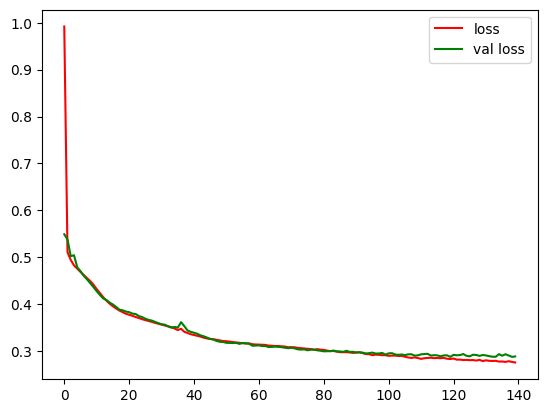

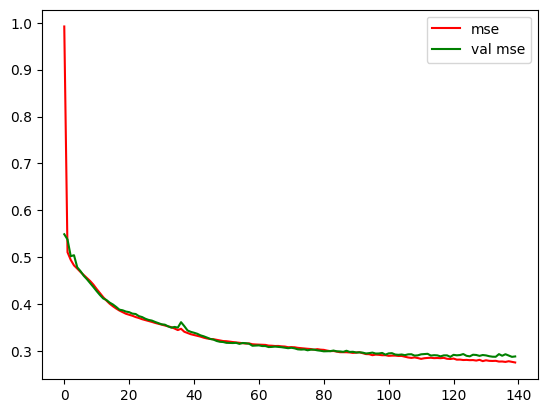

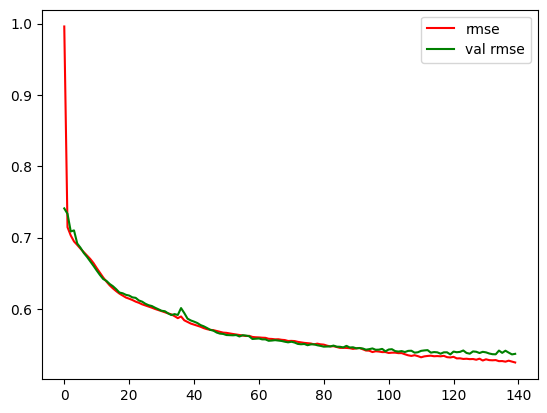

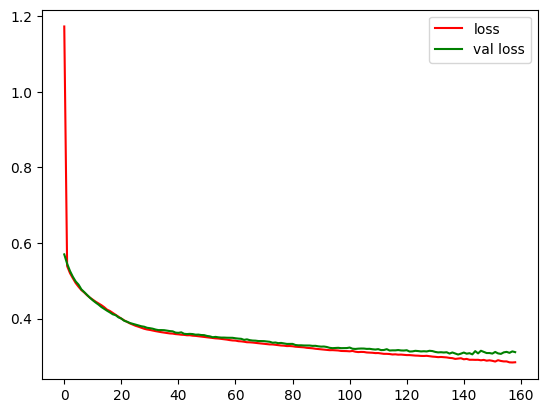

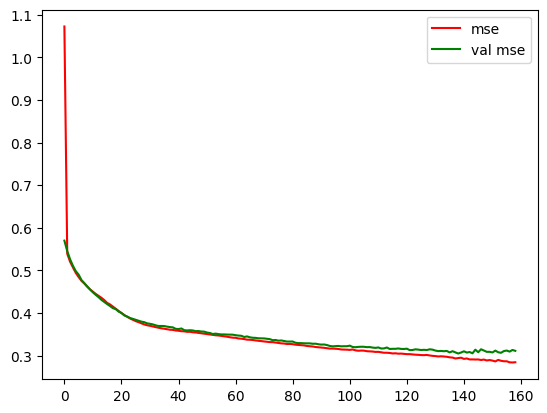

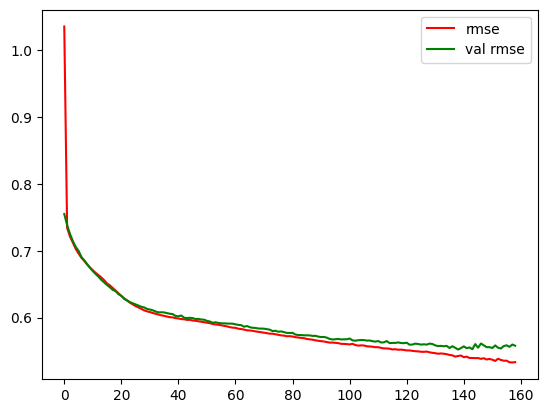

In [18]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [19]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type)
name = f"TINTO"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [20]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/california_housing/images_california_housing_TINTO\regression.csv
Images shape:  (20, 20, 3)
Attributres:  8
Image size (pixels): 20


Epoch 1/200
516/516 - 10s - 19ms/step - loss: 0.7538 - mae: 0.6095 - mse: 0.7016 - r_square: 0.3973 - rmse: 0.8376 - val_loss: 0.5307 - val_mae: 0.5210 - val_mse: 0.5307 - val_r_square: 0.5646 - val_rmse: 0.7285
Epoch 2/200
516/516 - 4s - 8ms/step - loss: 0.5097 - mae: 0.5166 - mse: 0.5097 - r_square: 0.5930 - rmse: 0.7139 - val_loss: 0.5131 - val_mae: 0.4993 - val_mse: 0.5131 - val_r_square: 0.5809 - val_rmse: 0.7163
Epoch 3/200
516/516 - 4s - 8ms/step - loss: 0.4917 - mae: 0.5046 - mse: 0.4917 - r_square: 0.6074 - rmse: 0.7012 - val_loss: 0.4934 - val_mae: 0.4902 - val_mse: 0.4934 - val_r_square: 0.5965 - val_rmse: 0.7024
Epoch 4/200
516/516 - 4s - 8ms/step - loss: 0.4798 - mae: 0.4966 - mse: 0.4798 - r_square: 0.6168 - rmse: 0.6927 - val_loss: 0.4804 - val_mae: 0.4858 - val_mse: 0.4804 - val_r_square: 0.6069 - val_rmse: 0.6931
Epoch 5/200
516/516 - 4s - 8ms/step - loss: 0.4701 - mae: 0.4905 - mse: 0.4701 - r_square: 0.6244 - rmse: 0.6856 - val_loss: 0.4712 - val_mae: 0.4795 - val_ms

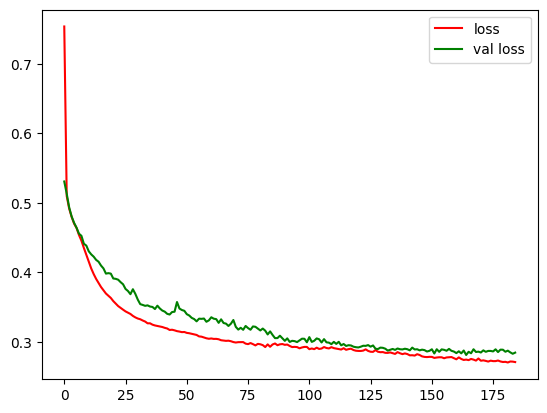

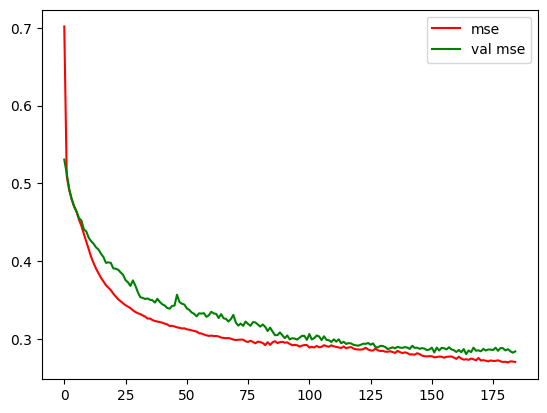

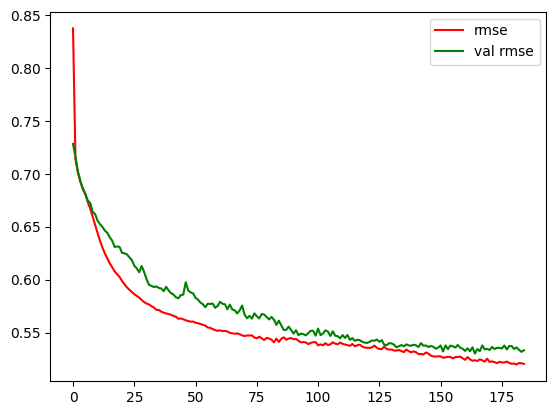

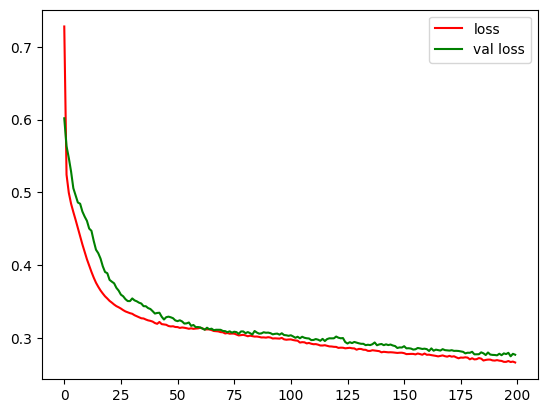

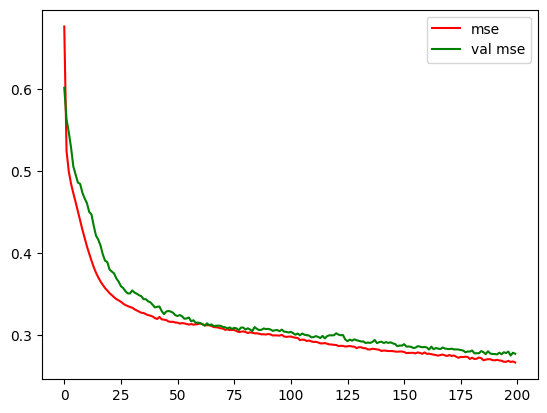

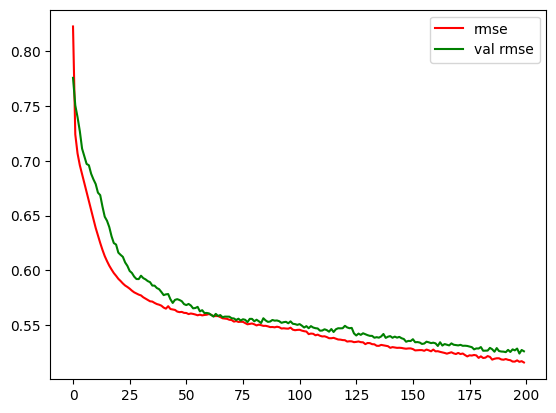

In [21]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

### EXPERIMENT 2: IGTD

In [22]:
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

3


In [23]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size])
name = f"IGTD_{image_size}x{image_size}"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [24]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/california_housing/images_california_housing_IGTD_3x3\regression.csv
Images shape:  (3, 3, 3)
Attributres:  8
Image size (pixels): 3


Epoch 1/200
516/516 - 10s - 18ms/step - loss: 0.9024 - mae: 0.6495 - mse: 0.8315 - r_square: 0.2776 - rmse: 0.9119 - val_loss: 0.5496 - val_mae: 0.5417 - val_mse: 0.5496 - val_r_square: 0.5479 - val_rmse: 0.7414
Epoch 2/200
516/516 - 3s - 7ms/step - loss: 0.5205 - mae: 0.5233 - mse: 0.5205 - r_square: 0.5840 - rmse: 0.7215 - val_loss: 0.5132 - val_mae: 0.5156 - val_mse: 0.5132 - val_r_square: 0.5786 - val_rmse: 0.7163
Epoch 3/200
516/516 - 3s - 6ms/step - loss: 0.4944 - mae: 0.5057 - mse: 0.4944 - r_square: 0.6053 - rmse: 0.7031 - val_loss: 0.4940 - val_mae: 0.5002 - val_mse: 0.4940 - val_r_square: 0.5930 - val_rmse: 0.7028
Epoch 4/200
516/516 - 3s - 6ms/step - loss: 0.4796 - mae: 0.4969 - mse: 0.4796 - r_square: 0.6171 - rmse: 0.6925 - val_loss: 0.4823 - val_mae: 0.4939 - val_mse: 0.4823 - val_r_square: 0.6037 - val_rmse: 0.6945
Epoch 5/200
516/516 - 3s - 6ms/step - loss: 0.4663 - mae: 0.4866 - mse: 0.4663 - r_square: 0.6281 - rmse: 0.6828 - val_loss: 0.4722 - val_mae: 0.4825 - val_ms

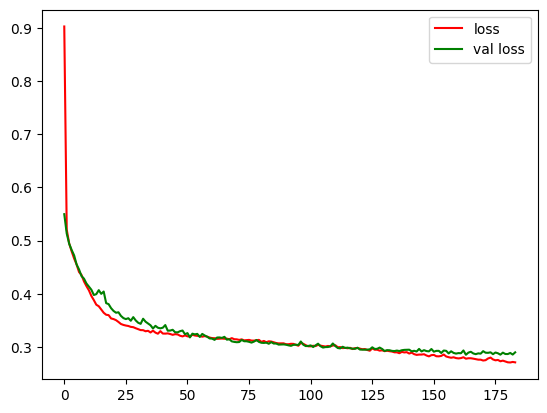

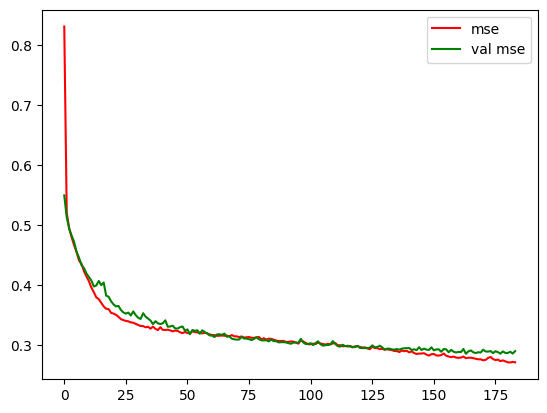

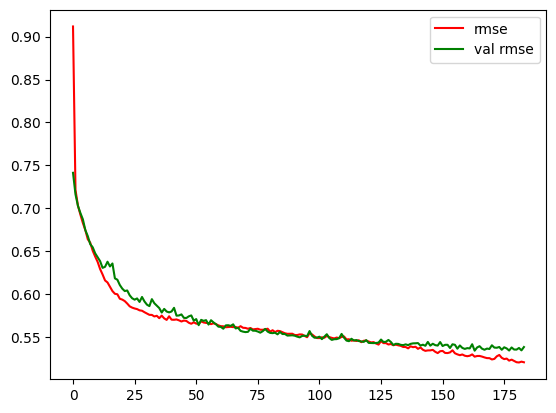

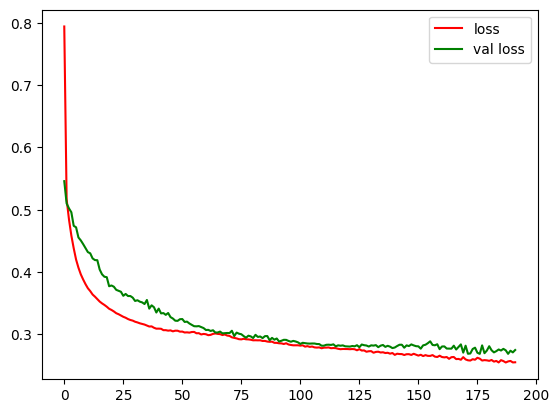

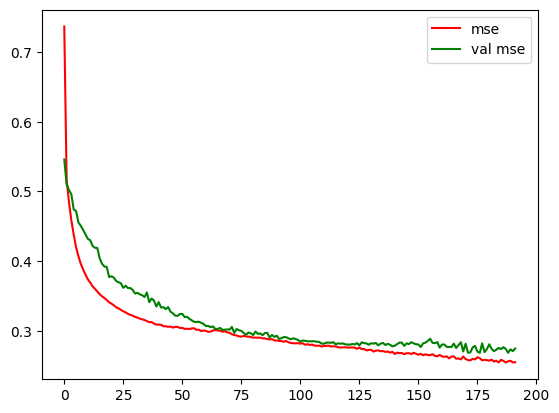

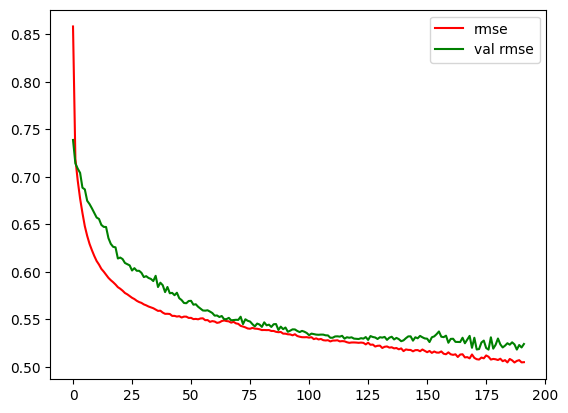

In [25]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [26]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], zoom=2)
name = f"IGTD_{image_size*2}x{image_size*2}"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [27]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/california_housing/images_california_housing_IGTD_6x6\regression.csv
Images shape:  (6, 6, 3)
Attributres:  8
Image size (pixels): 6


Epoch 1/200
516/516 - 9s - 18ms/step - loss: 1.1373 - mae: 0.7182 - mse: 1.0397 - r_square: 0.0932 - rmse: 1.0196 - val_loss: 0.5499 - val_mae: 0.5410 - val_mse: 0.5499 - val_r_square: 0.5470 - val_rmse: 0.7416
Epoch 2/200
516/516 - 3s - 7ms/step - loss: 0.5339 - mae: 0.5326 - mse: 0.5339 - r_square: 0.5740 - rmse: 0.7307 - val_loss: 0.5231 - val_mae: 0.5257 - val_mse: 0.5231 - val_r_square: 0.5714 - val_rmse: 0.7233
Epoch 3/200
516/516 - 3s - 6ms/step - loss: 0.5061 - mae: 0.5131 - mse: 0.5061 - r_square: 0.5961 - rmse: 0.7114 - val_loss: 0.5130 - val_mae: 0.5277 - val_mse: 0.5130 - val_r_square: 0.5775 - val_rmse: 0.7163
Epoch 4/200
516/516 - 4s - 7ms/step - loss: 0.4940 - mae: 0.5045 - mse: 0.4940 - r_square: 0.6062 - rmse: 0.7029 - val_loss: 0.4894 - val_mae: 0.5097 - val_mse: 0.4894 - val_r_square: 0.5971 - val_rmse: 0.6996
Epoch 5/200
516/516 - 3s - 6ms/step - loss: 0.4810 - mae: 0.4954 - mse: 0.4810 - r_square: 0.6167 - rmse: 0.6935 - val_loss: 0.4833 - val_mae: 0.5062 - val_mse

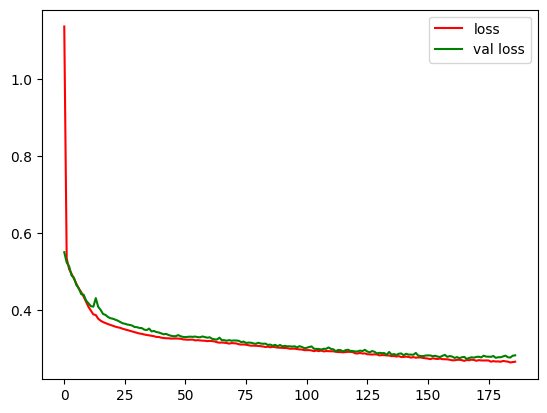

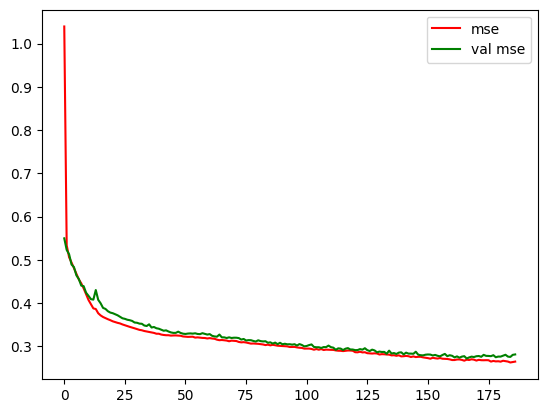

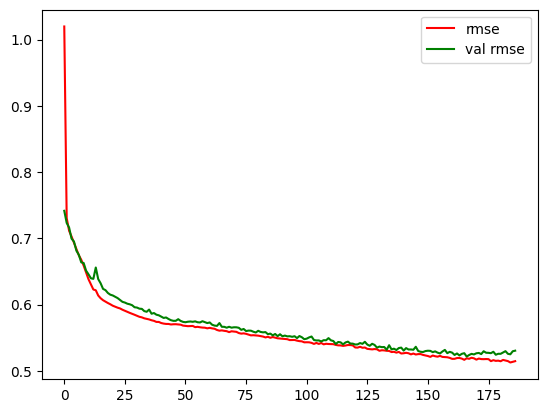

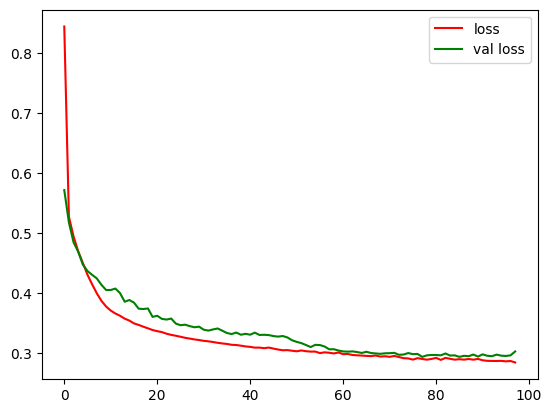

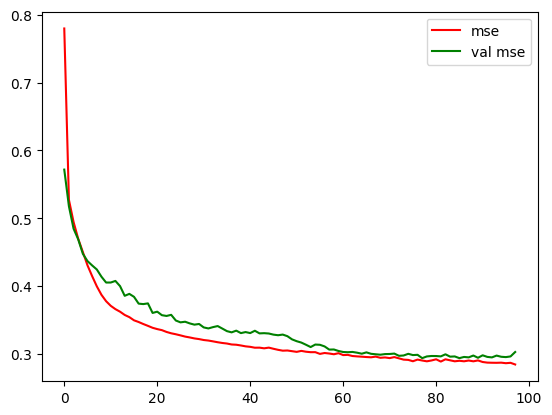

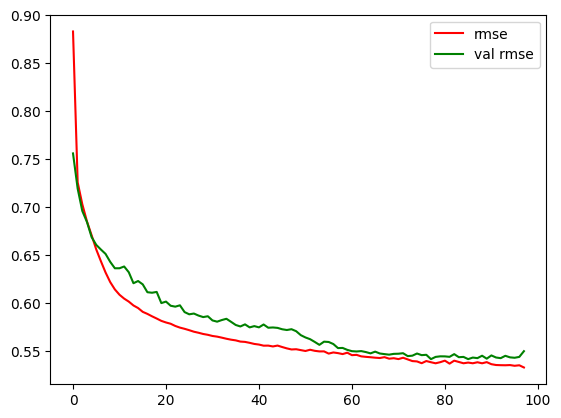

In [28]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [29]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], zoom=4)
name = f"IGTD_{image_size*4}x{image_size*4}"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [30]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/california_housing/images_california_housing_IGTD_12x12\regression.csv
Images shape:  (12, 12, 3)
Attributres:  8
Image size (pixels): 12


Epoch 1/200
516/516 - 10s - 19ms/step - loss: 0.9104 - mae: 0.6575 - mse: 0.8388 - r_square: 0.2728 - rmse: 0.9159 - val_loss: 0.5592 - val_mae: 0.5392 - val_mse: 0.5592 - val_r_square: 0.5421 - val_rmse: 0.7478
Epoch 2/200
516/516 - 3s - 7ms/step - loss: 0.5351 - mae: 0.5335 - mse: 0.5351 - r_square: 0.5727 - rmse: 0.7315 - val_loss: 0.5325 - val_mae: 0.5298 - val_mse: 0.5325 - val_r_square: 0.5625 - val_rmse: 0.7297
Epoch 3/200
516/516 - 4s - 7ms/step - loss: 0.5096 - mae: 0.5158 - mse: 0.5096 - r_square: 0.5936 - rmse: 0.7139 - val_loss: 0.5071 - val_mae: 0.5089 - val_mse: 0.5071 - val_r_square: 0.5840 - val_rmse: 0.7121
Epoch 4/200
516/516 - 4s - 7ms/step - loss: 0.4914 - mae: 0.5034 - mse: 0.4914 - r_square: 0.6082 - rmse: 0.7010 - val_loss: 0.5697 - val_mae: 0.5041 - val_mse: 0.5697 - val_r_square: 0.5358 - val_rmse: 0.7548
Epoch 5/200
516/516 - 3s - 7ms/step - loss: 0.4738 - mae: 0.4927 - mse: 0.4738 - r_square: 0.6225 - rmse: 0.6883 - val_loss: 0.4667 - val_mae: 0.4850 - val_ms

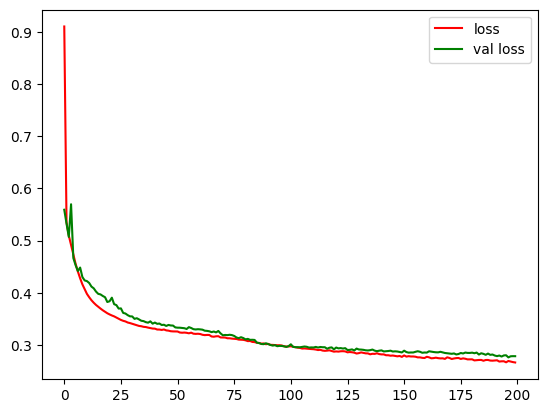

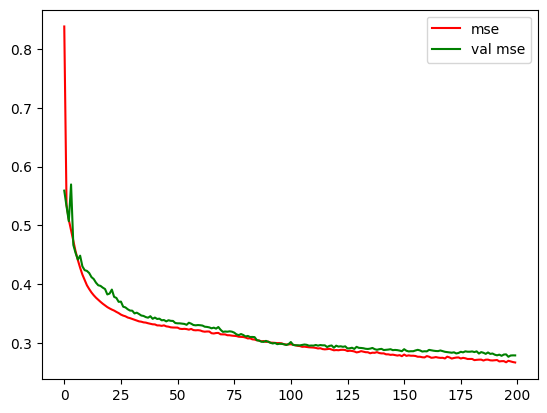

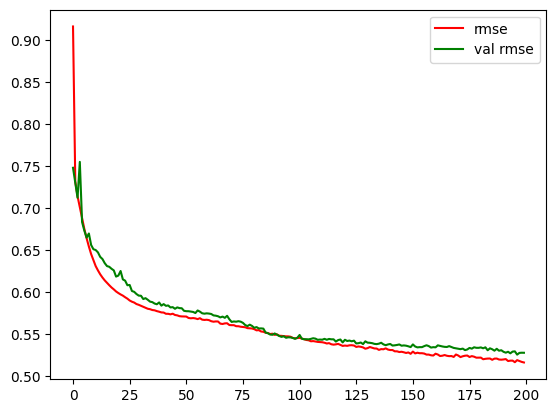

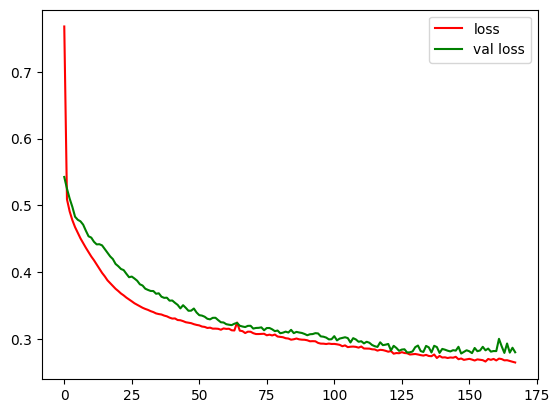

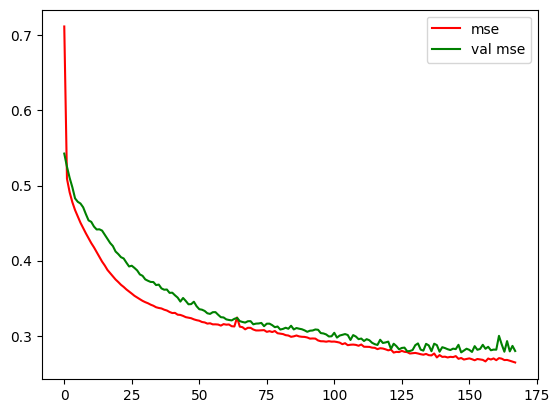

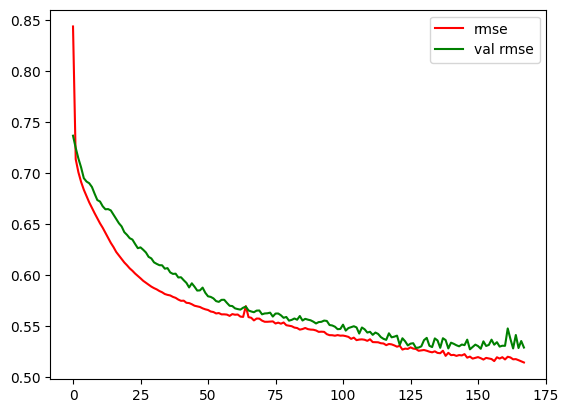

In [31]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [32]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean')
name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [33]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/california_housing/images_california_housing_IGTD_3x3_fEuclidean_iEuclidean\regression.csv
Images shape:  (3, 3, 3)
Attributres:  8
Image size (pixels): 3


Epoch 1/200
516/516 - 9s - 18ms/step - loss: 0.7405 - mae: 0.6010 - mse: 0.6883 - r_square: 0.4077 - rmse: 0.8296 - val_loss: 0.5838 - val_mae: 0.5161 - val_mse: 0.5838 - val_r_square: 0.5259 - val_rmse: 0.7641
Epoch 2/200
516/516 - 4s - 7ms/step - loss: 0.5081 - mae: 0.5165 - mse: 0.5081 - r_square: 0.5935 - rmse: 0.7128 - val_loss: 0.5051 - val_mae: 0.4975 - val_mse: 0.5051 - val_r_square: 0.5883 - val_rmse: 0.7107
Epoch 3/200
516/516 - 3s - 6ms/step - loss: 0.4894 - mae: 0.5026 - mse: 0.4894 - r_square: 0.6092 - rmse: 0.6996 - val_loss: 0.5046 - val_mae: 0.5008 - val_mse: 0.5046 - val_r_square: 0.5881 - val_rmse: 0.7104
Epoch 4/200
516/516 - 4s - 8ms/step - loss: 0.4732 - mae: 0.4906 - mse: 0.4732 - r_square: 0.6220 - rmse: 0.6879 - val_loss: 0.4859 - val_mae: 0.4893 - val_mse: 0.4859 - val_r_square: 0.6042 - val_rmse: 0.6971
Epoch 5/200
516/516 - 3s - 7ms/step - loss: 0.4638 - mae: 0.4834 - mse: 0.4638 - r_square: 0.6300 - rmse: 0.6811 - val_loss: 0.4674 - val_mae: 0.4824 - val_mse

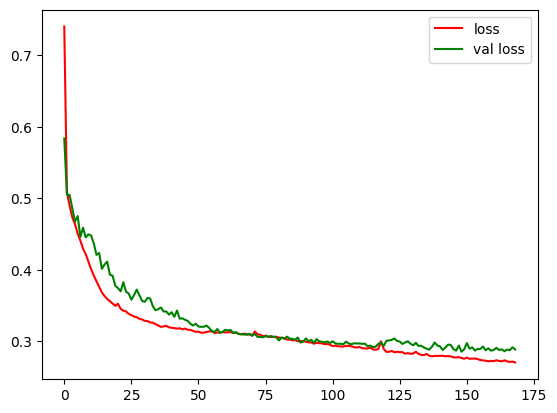

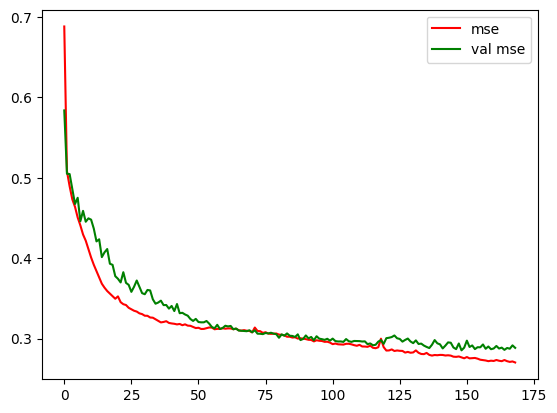

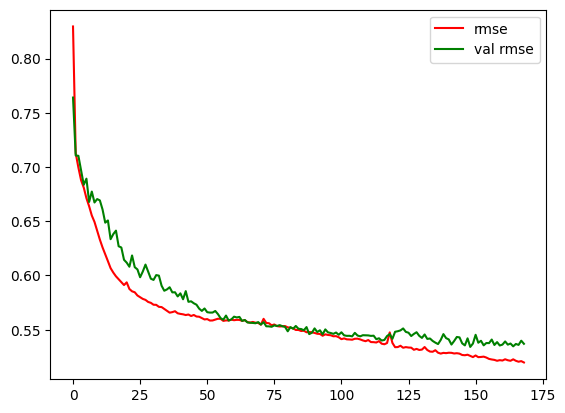

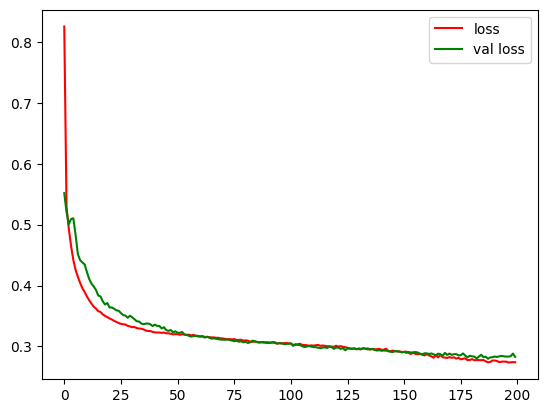

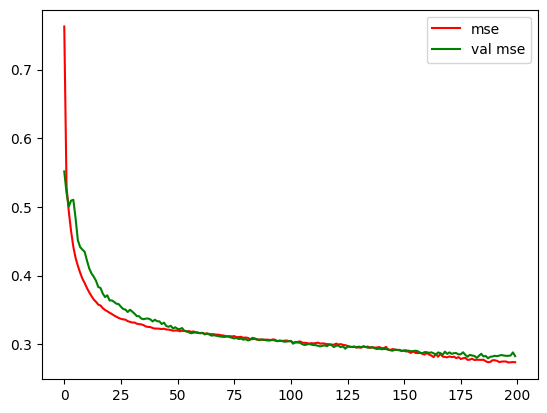

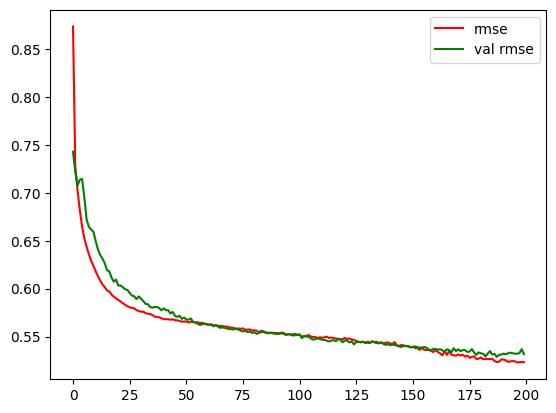

In [34]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

### EXPERIMENT 3: REFINED

In [35]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type)
name = f"REFINED"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [36]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/california_housing/images_california_housing_REFINED\regression.csv
Images shape:  (3, 3, 3)
Attributres:  8
Image size (pixels): 3


Epoch 1/200
516/516 - 10s - 20ms/step - loss: 1.0424 - mae: 0.6951 - mse: 0.9571 - r_square: 0.1705 - rmse: 0.9783 - val_loss: 0.5520 - val_mae: 0.5534 - val_mse: 0.5520 - val_r_square: 0.5436 - val_rmse: 0.7430
Epoch 2/200
516/516 - 4s - 9ms/step - loss: 0.5267 - mae: 0.5285 - mse: 0.5267 - r_square: 0.5795 - rmse: 0.7257 - val_loss: 0.5137 - val_mae: 0.5160 - val_mse: 0.5137 - val_r_square: 0.5770 - val_rmse: 0.7167
Epoch 3/200
516/516 - 4s - 8ms/step - loss: 0.4963 - mae: 0.5087 - mse: 0.4963 - r_square: 0.6039 - rmse: 0.7045 - val_loss: 0.4911 - val_mae: 0.4904 - val_mse: 0.4911 - val_r_square: 0.5972 - val_rmse: 0.7008
Epoch 4/200
516/516 - 4s - 8ms/step - loss: 0.4765 - mae: 0.4966 - mse: 0.4765 - r_square: 0.6191 - rmse: 0.6903 - val_loss: 0.4790 - val_mae: 0.4764 - val_mse: 0.4790 - val_r_square: 0.6084 - val_rmse: 0.6921
Epoch 5/200
516/516 - 4s - 9ms/step - loss: 0.4598 - mae: 0.4862 - mse: 0.4598 - r_square: 0.6324 - rmse: 0.6781 - val_loss: 0.4629 - val_mae: 0.4675 - val_ms

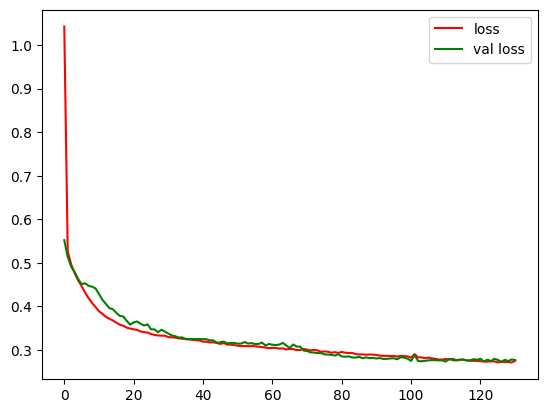

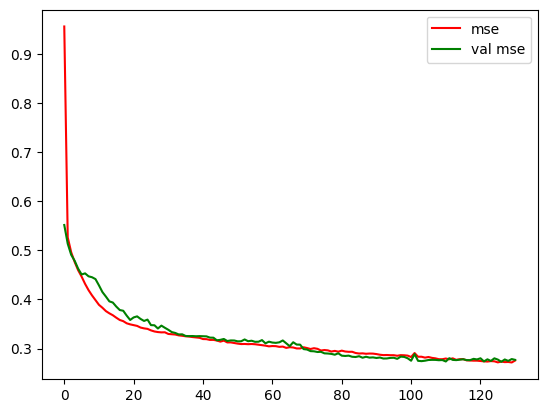

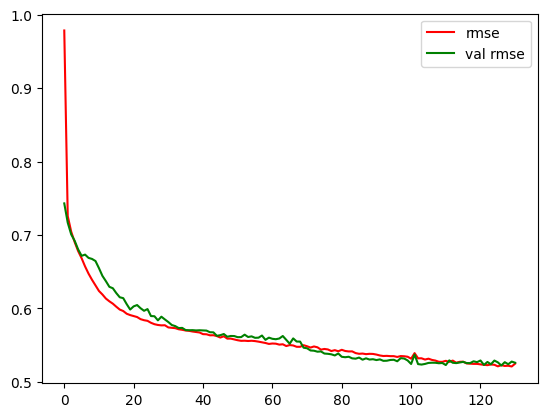

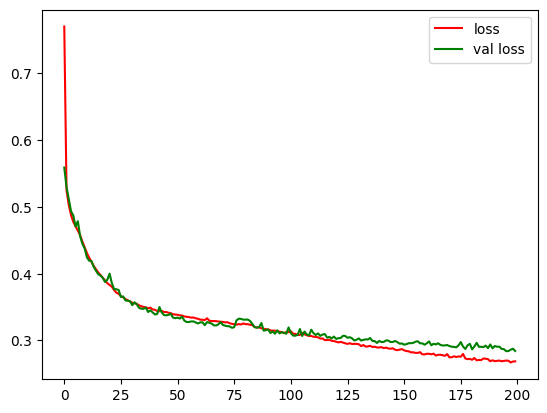

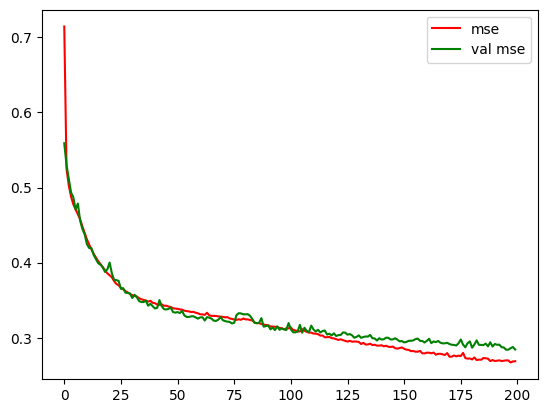

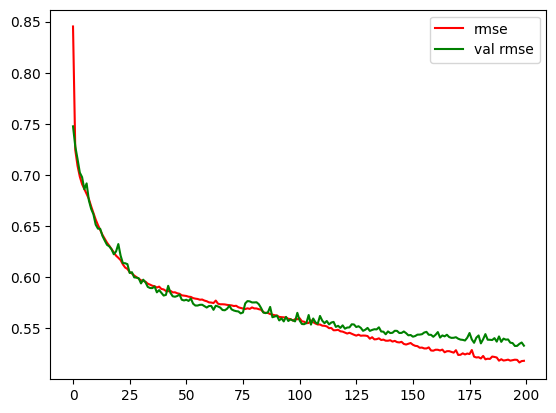

In [37]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [38]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type, zoom=2)
name = f"REFINED_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [39]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/california_housing/images_california_housing_REFINED_zoom2\regression.csv
Images shape:  (6, 6, 3)
Attributres:  8
Image size (pixels): 6


Epoch 1/200
516/516 - 10s - 19ms/step - loss: 0.7601 - mae: 0.6105 - mse: 0.7044 - r_square: 0.3933 - rmse: 0.8393 - val_loss: 0.5374 - val_mae: 0.5327 - val_mse: 0.5374 - val_r_square: 0.5576 - val_rmse: 0.7331
Epoch 2/200
516/516 - 4s - 9ms/step - loss: 0.5140 - mae: 0.5191 - mse: 0.5140 - r_square: 0.5901 - rmse: 0.7169 - val_loss: 0.5115 - val_mae: 0.5159 - val_mse: 0.5115 - val_r_square: 0.5792 - val_rmse: 0.7152
Epoch 3/200
516/516 - 4s - 8ms/step - loss: 0.4949 - mae: 0.5070 - mse: 0.4949 - r_square: 0.6053 - rmse: 0.7035 - val_loss: 0.4914 - val_mae: 0.4972 - val_mse: 0.4914 - val_r_square: 0.5965 - val_rmse: 0.7010
Epoch 4/200
516/516 - 5s - 9ms/step - loss: 0.4828 - mae: 0.4994 - mse: 0.4828 - r_square: 0.6147 - rmse: 0.6949 - val_loss: 0.4765 - val_mae: 0.4901 - val_mse: 0.4765 - val_r_square: 0.6086 - val_rmse: 0.6903
Epoch 5/200
516/516 - 4s - 8ms/step - loss: 0.4715 - mae: 0.4918 - mse: 0.4715 - r_square: 0.6236 - rmse: 0.6866 - val_loss: 0.4680 - val_mae: 0.4812 - val_ms

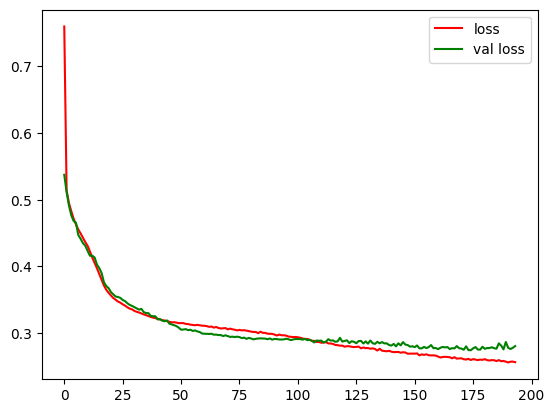

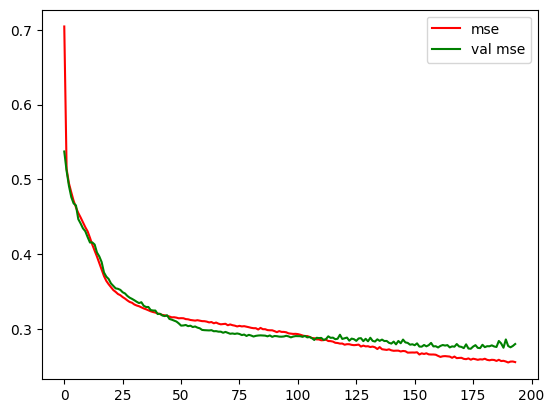

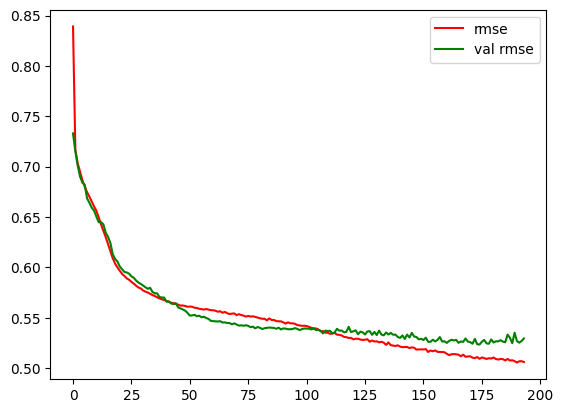

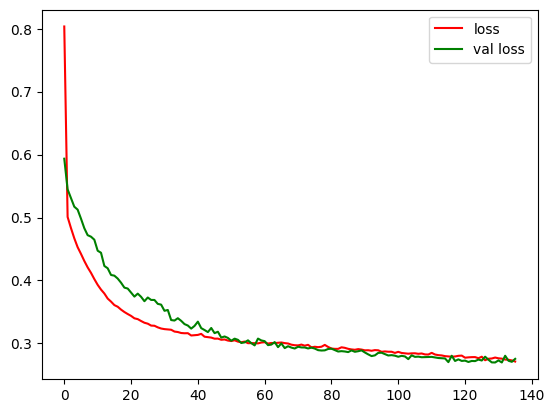

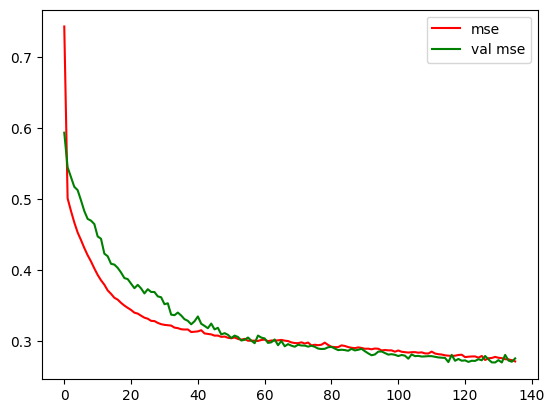

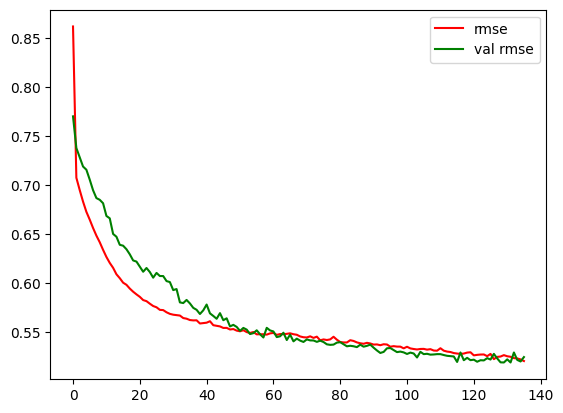

In [40]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [41]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type, zoom=4)
name = f"REFINED_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [42]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/california_housing/images_california_housing_REFINED_zoom4\regression.csv
Images shape:  (12, 12, 3)
Attributres:  8
Image size (pixels): 12


Epoch 1/200
516/516 - 9s - 18ms/step - loss: 0.8045 - mae: 0.6264 - mse: 0.7441 - r_square: 0.3576 - rmse: 0.8626 - val_loss: 0.5434 - val_mae: 0.5362 - val_mse: 0.5434 - val_r_square: 0.5514 - val_rmse: 0.7371
Epoch 2/200
516/516 - 4s - 8ms/step - loss: 0.5173 - mae: 0.5203 - mse: 0.5173 - r_square: 0.5870 - rmse: 0.7192 - val_loss: 0.5108 - val_mae: 0.5125 - val_mse: 0.5108 - val_r_square: 0.5803 - val_rmse: 0.7147
Epoch 3/200
516/516 - 4s - 8ms/step - loss: 0.4940 - mae: 0.5047 - mse: 0.4940 - r_square: 0.6060 - rmse: 0.7028 - val_loss: 0.4914 - val_mae: 0.4964 - val_mse: 0.4914 - val_r_square: 0.5979 - val_rmse: 0.7010
Epoch 4/200
516/516 - 4s - 7ms/step - loss: 0.4775 - mae: 0.4946 - mse: 0.4775 - r_square: 0.6189 - rmse: 0.6910 - val_loss: 0.4773 - val_mae: 0.4830 - val_mse: 0.4773 - val_r_square: 0.6102 - val_rmse: 0.6909
Epoch 5/200
516/516 - 4s - 8ms/step - loss: 0.4645 - mae: 0.4863 - mse: 0.4645 - r_square: 0.6293 - rmse: 0.6815 - val_loss: 0.4655 - val_mae: 0.4700 - val_mse

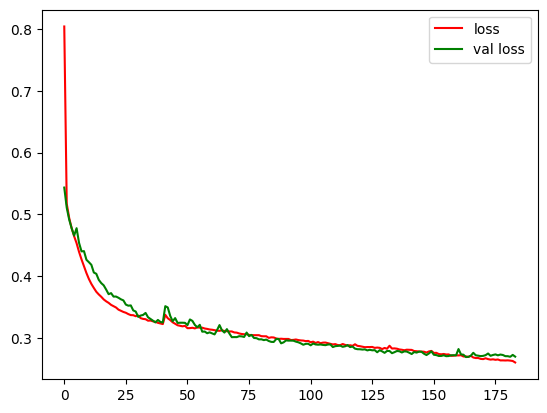

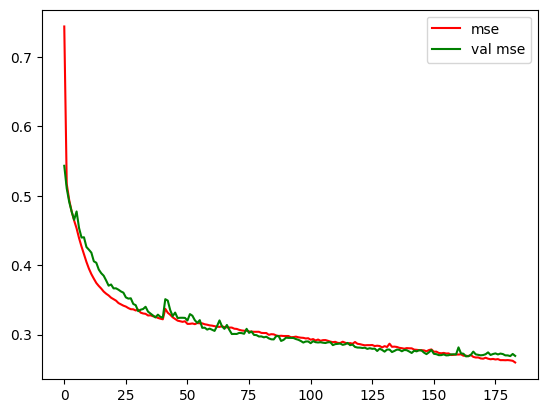

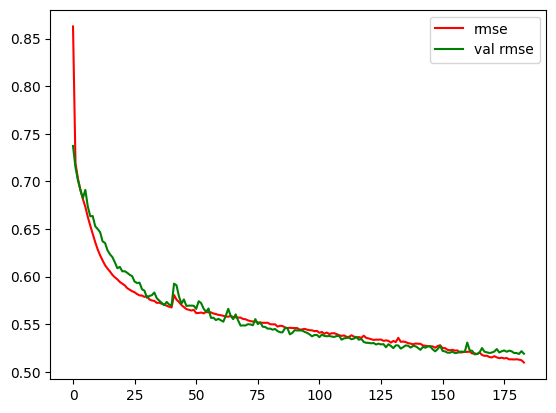

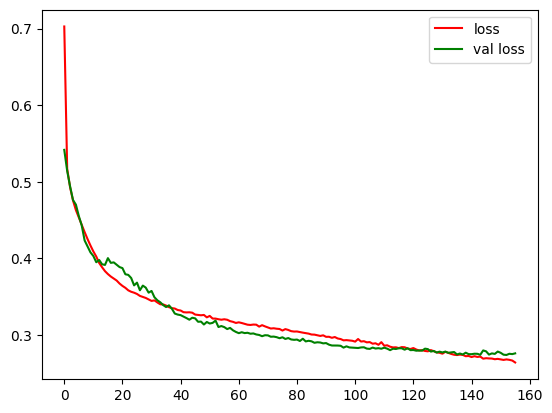

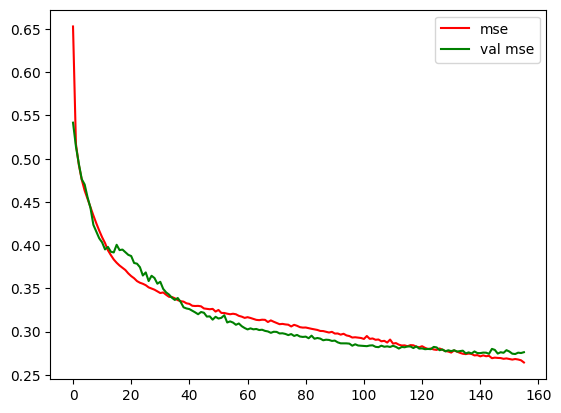

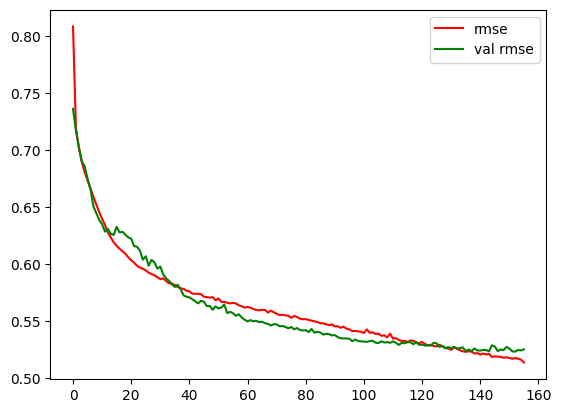

In [43]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

### EXPERIMENT 4: BAR GRAPH

In [44]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem= problem_type)
name = f"BarGraph"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [45]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/california_housing/images_california_housing_BarGraph\regression.csv
Images shape:  (8, 8, 3)
Attributres:  8
Image size (pixels): 8


Epoch 1/200
516/516 - 9s - 18ms/step - loss: 0.8788 - mae: 0.6375 - mse: 0.8104 - r_square: 0.2921 - rmse: 0.9002 - val_loss: 0.5785 - val_mae: 0.5604 - val_mse: 0.5785 - val_r_square: 0.5193 - val_rmse: 0.7606
Epoch 2/200
516/516 - 4s - 7ms/step - loss: 0.5139 - mae: 0.5167 - mse: 0.5139 - r_square: 0.5895 - rmse: 0.7169 - val_loss: 0.4956 - val_mae: 0.5071 - val_mse: 0.4956 - val_r_square: 0.5923 - val_rmse: 0.7040
Epoch 3/200
516/516 - 3s - 6ms/step - loss: 0.4758 - mae: 0.4918 - mse: 0.4758 - r_square: 0.6204 - rmse: 0.6898 - val_loss: 0.4752 - val_mae: 0.4936 - val_mse: 0.4752 - val_r_square: 0.6094 - val_rmse: 0.6894
Epoch 4/200
516/516 - 3s - 7ms/step - loss: 0.4616 - mae: 0.4825 - mse: 0.4616 - r_square: 0.6319 - rmse: 0.6794 - val_loss: 0.4610 - val_mae: 0.4841 - val_mse: 0.4610 - val_r_square: 0.6209 - val_rmse: 0.6790
Epoch 5/200
516/516 - 4s - 7ms/step - loss: 0.4514 - mae: 0.4755 - mse: 0.4514 - r_square: 0.6397 - rmse: 0.6718 - val_loss: 0.4506 - val_mae: 0.4751 - val_mse

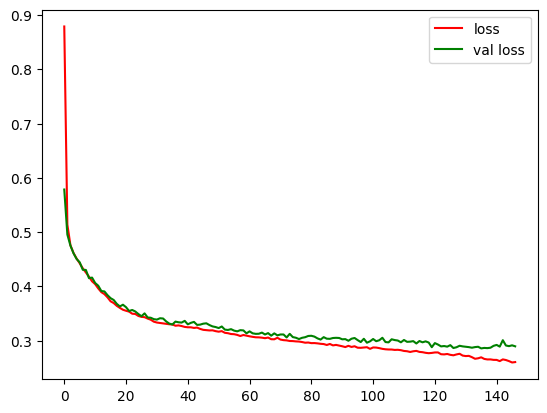

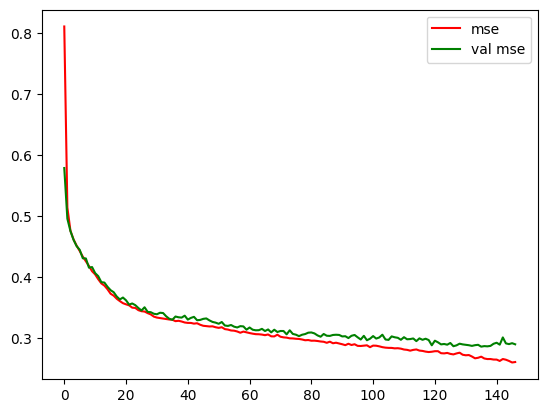

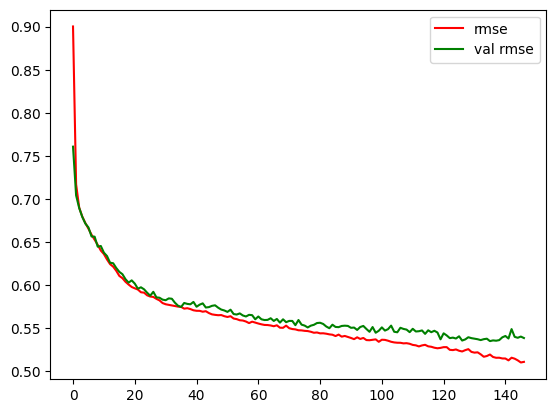

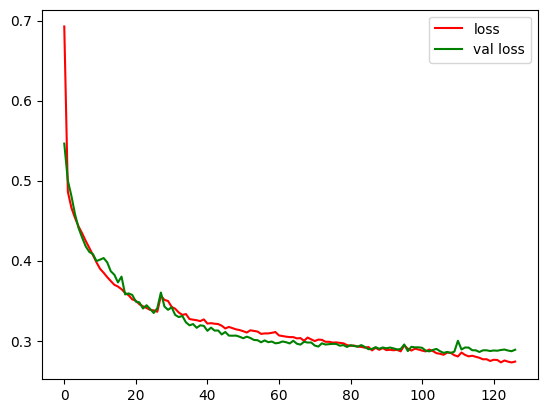

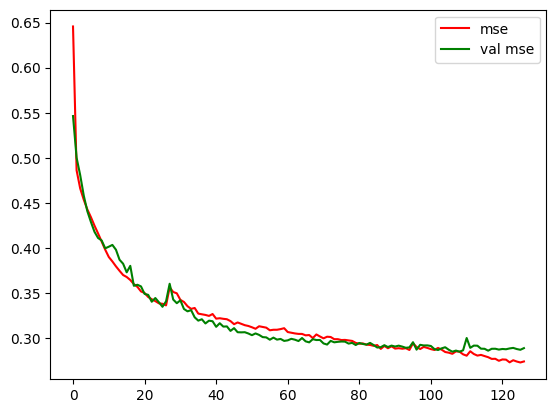

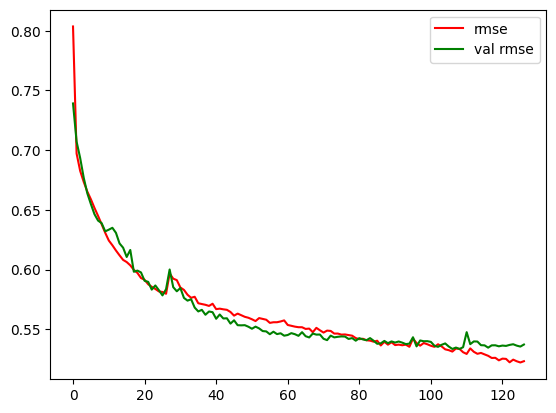

In [46]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [47]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem= problem_type, zoom=2)
name = f"BarGraph_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [48]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/california_housing/images_california_housing_BarGraph_zoom2\regression.csv
Images shape:  (16, 16, 3)
Attributres:  8
Image size (pixels): 16


Epoch 1/200
516/516 - 10s - 20ms/step - loss: 0.7218 - mae: 0.5929 - mse: 0.6708 - r_square: 0.4234 - rmse: 0.8190 - val_loss: 0.5543 - val_mae: 0.5499 - val_mse: 0.5543 - val_r_square: 0.5436 - val_rmse: 0.7445
Epoch 2/200
516/516 - 4s - 8ms/step - loss: 0.5066 - mae: 0.5121 - mse: 0.5066 - r_square: 0.5954 - rmse: 0.7118 - val_loss: 0.4942 - val_mae: 0.4992 - val_mse: 0.4942 - val_r_square: 0.5953 - val_rmse: 0.7030
Epoch 3/200
516/516 - 4s - 8ms/step - loss: 0.4777 - mae: 0.4918 - mse: 0.4777 - r_square: 0.6189 - rmse: 0.6912 - val_loss: 0.4802 - val_mae: 0.4931 - val_mse: 0.4802 - val_r_square: 0.6066 - val_rmse: 0.6929
Epoch 4/200
516/516 - 4s - 8ms/step - loss: 0.4646 - mae: 0.4836 - mse: 0.4646 - r_square: 0.6294 - rmse: 0.6816 - val_loss: 0.4685 - val_mae: 0.4854 - val_mse: 0.4685 - val_r_square: 0.6162 - val_rmse: 0.6845
Epoch 5/200
516/516 - 4s - 8ms/step - loss: 0.4548 - mae: 0.4774 - mse: 0.4548 - r_square: 0.6370 - rmse: 0.6744 - val_loss: 0.4697 - val_mae: 0.4718 - val_ms

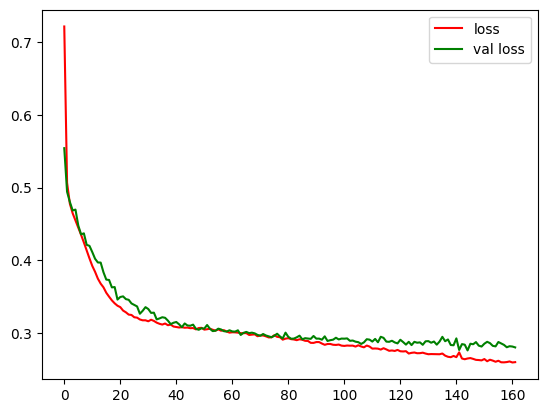

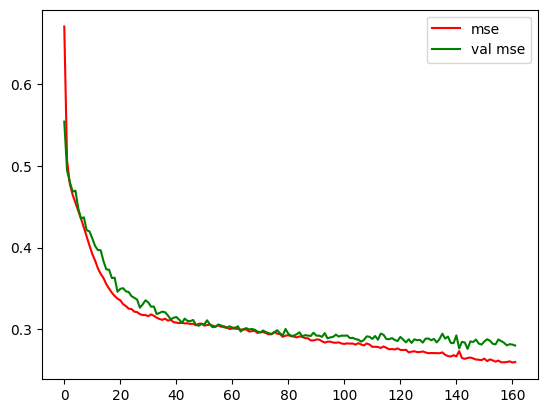

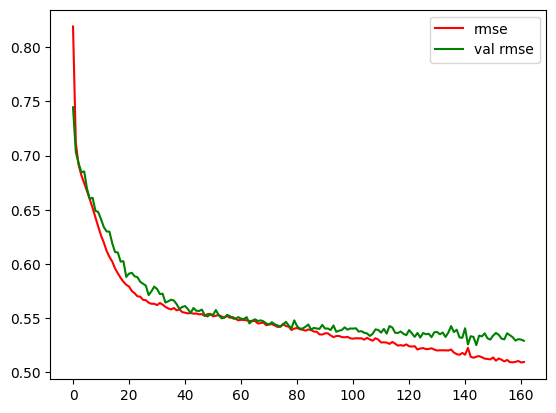

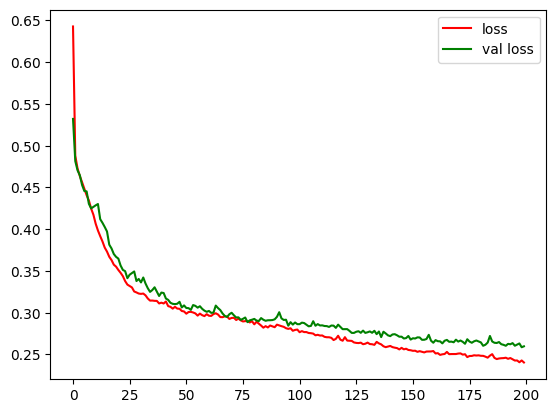

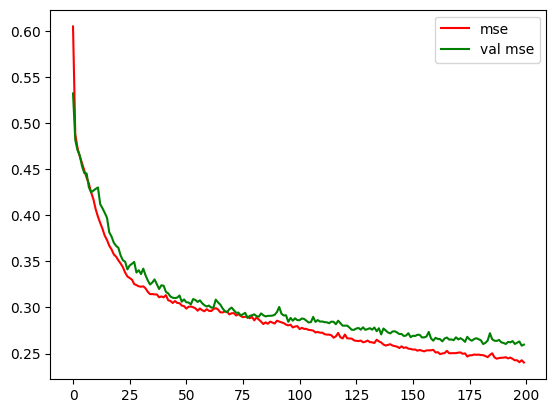

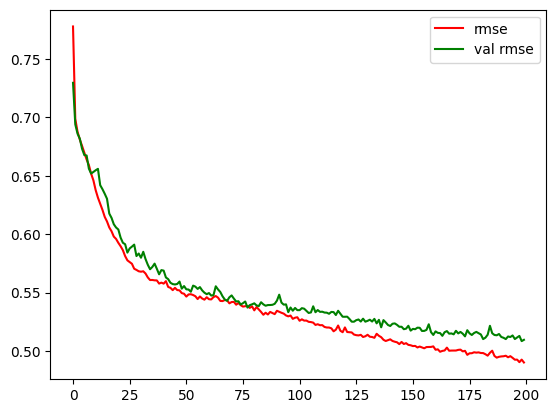

In [49]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [50]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem= problem_type, zoom=4)
name = f"BarGraph_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [51]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/california_housing/images_california_housing_BarGraph_zoom4\regression.csv
Images shape:  (32, 32, 3)
Attributres:  8
Image size (pixels): 32


Epoch 1/200
516/516 - 37s - 72ms/step - loss: 1.2099 - mae: 0.7366 - mse: 1.1038 - r_square: 0.0211 - rmse: 1.0506 - val_loss: 0.6442 - val_mae: 0.6184 - val_mse: 0.6442 - val_r_square: 0.4638 - val_rmse: 0.8026
Epoch 2/200
516/516 - 32s - 62ms/step - loss: 0.5929 - mae: 0.5650 - mse: 0.5929 - r_square: 0.5259 - rmse: 0.7700 - val_loss: 0.5425 - val_mae: 0.5478 - val_mse: 0.5425 - val_r_square: 0.5522 - val_rmse: 0.7366
Epoch 3/200
516/516 - 31s - 60ms/step - loss: 0.4976 - mae: 0.5082 - mse: 0.4976 - r_square: 0.6027 - rmse: 0.7054 - val_loss: 0.4829 - val_mae: 0.4953 - val_mse: 0.4829 - val_r_square: 0.6035 - val_rmse: 0.6949
Epoch 4/200
516/516 - 30s - 59ms/step - loss: 0.4654 - mae: 0.4858 - mse: 0.4654 - r_square: 0.6288 - rmse: 0.6822 - val_loss: 0.4647 - val_mae: 0.4823 - val_mse: 0.4647 - val_r_square: 0.6188 - val_rmse: 0.6817
Epoch 5/200
516/516 - 30s - 59ms/step - loss: 0.4517 - mae: 0.4773 - mse: 0.4517 - r_square: 0.6400 - rmse: 0.6721 - val_loss: 0.4542 - val_mae: 0.4735 

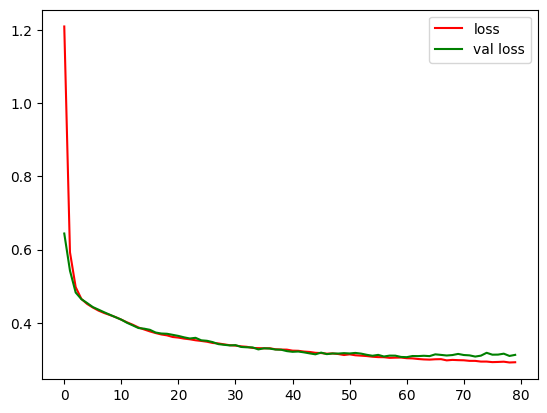

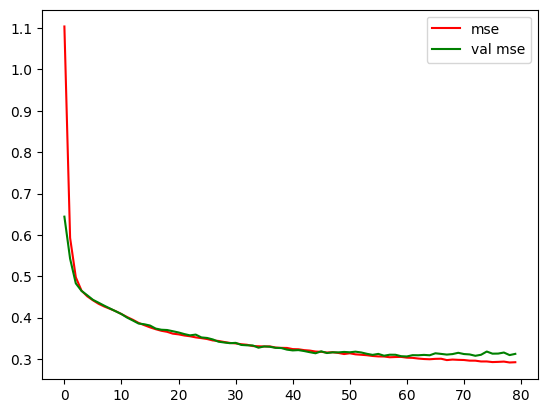

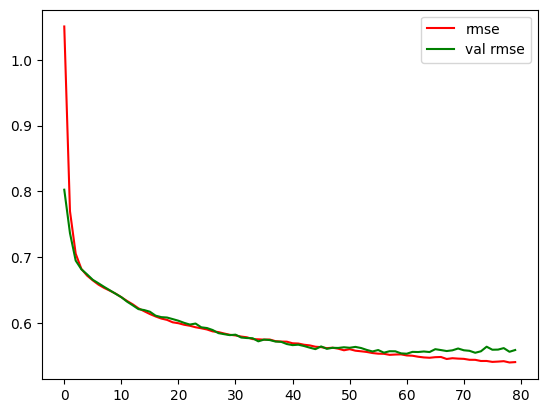

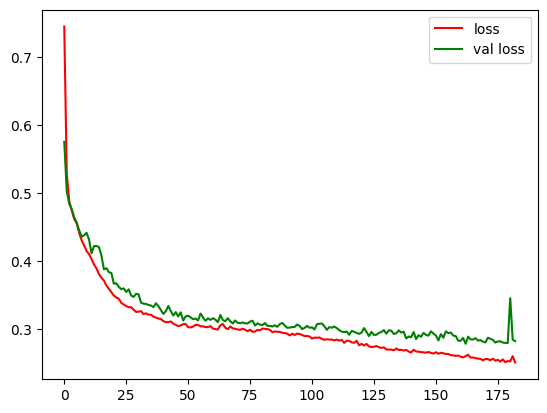

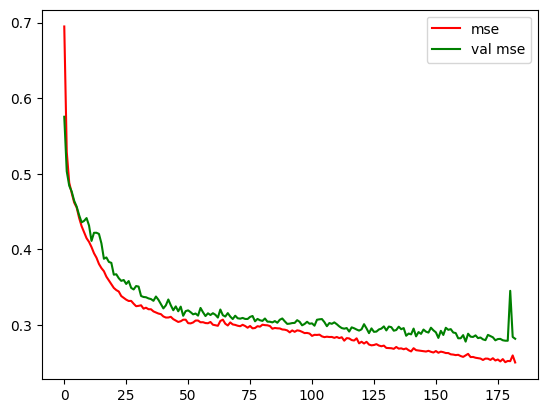

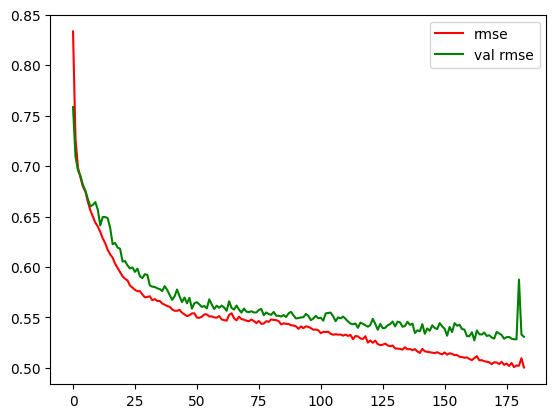

In [52]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

### EXPERIMENT 5: DISTANCE MATRIX

In [18]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type)
name = f"DistanceMatrix"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [19]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

The images are already generated
../HyNNImages/Regression/california_housing/images_california_housing_DistanceMatrix\regression.csv
Images shape:  (8, 8, 3)
Attributres:  8
Image size (pixels): 8



Epoch 1/200
516/516 - 9s - 16ms/step - loss: 0.9748 - mae: 0.7055 - mse: 0.9748 - r_square: 0.2223 - rmse: 0.9873 - val_loss: 0.5324 - val_mae: 0.5291 - val_mse: 0.5324 - val_r_square: 0.5626 - val_rmse: 0.7296
Epoch 2/200
516/516 - 3s - 6ms/step - loss: 0.5121 - mae: 0.5195 - mse: 0.5121 - r_square: 0.5911 - rmse: 0.7156 - val_loss: 0.5126 - val_mae: 0.5128 - val_mse: 0.5126 - val_r_square: 0.5783 - val_rmse: 0.7159
Epoch 3/200
516/516 - 3s - 5ms/step - loss: 0.4969 - mae: 0.5087 - mse: 0.4969 - r_square: 0.6038 - rmse: 0.7049 - val_loss: 0.4978 - val_mae: 0.5027 - val_mse: 0.4978 - val_r_square: 0.5908 - val_rmse: 0.7055
Epoch 4/200
516/516 - 3s - 6ms/step - loss: 0.4867 - mae: 0.5013 - mse: 0.4867 - r_square: 0.6120 - rmse: 0.6977 - val_loss: 0.4869 - val_mae: 0.4985 - val_mse: 0.4869 - val_r_square: 0.5993 - val_rmse: 0.6978
Epoch 5/200
516/516 - 3s - 5ms/step - loss: 0.4786 - mae: 0.4956 - mse: 0.4786 - r_square: 0.6185 - rmse: 0.6918 - val_loss: 0.4772 - val_mae: 0.4915 - val_ms

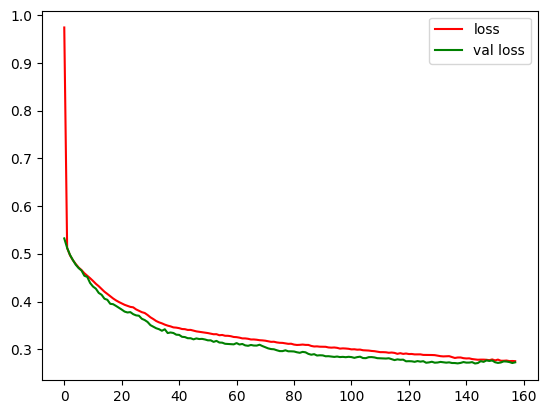

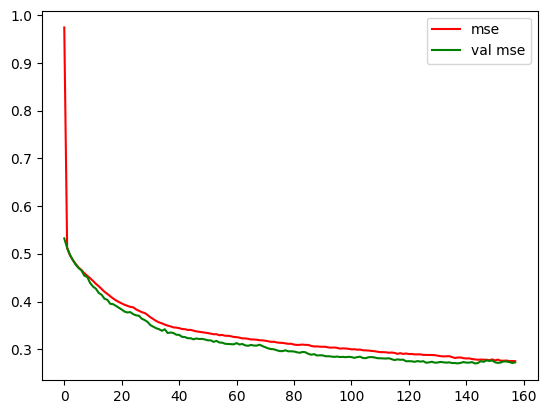

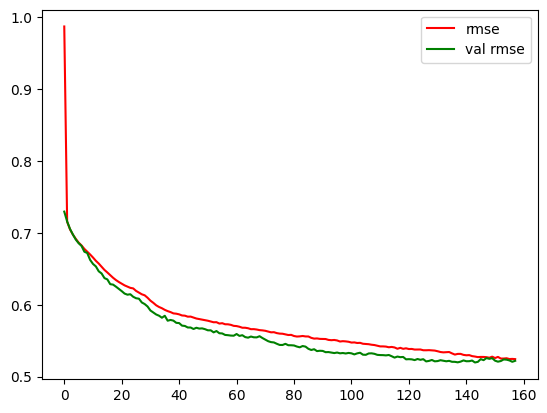

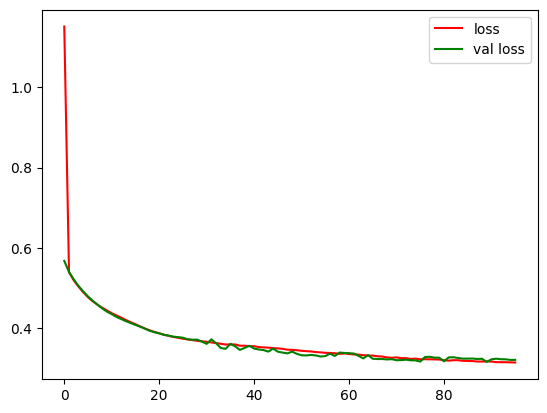

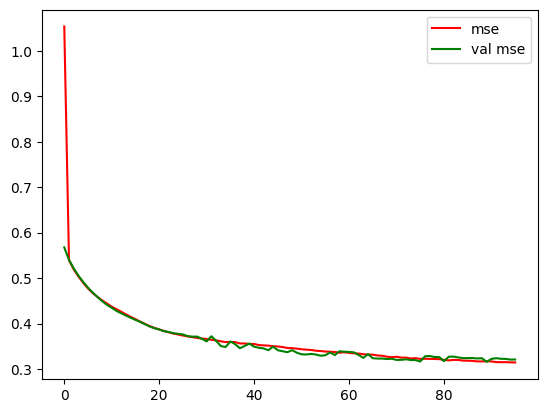

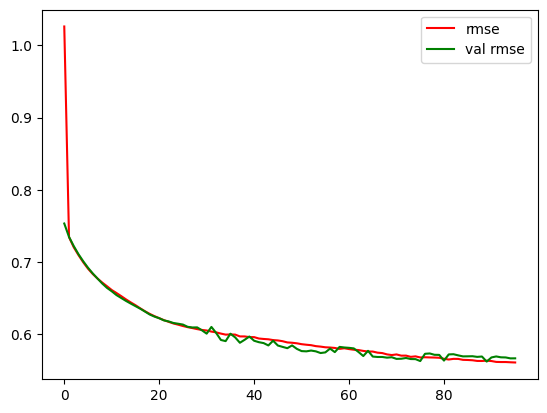

In [20]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [21]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type, zoom=2)
name = f"DistanceMatrix_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [22]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/california_housing/images_california_housing_DistanceMatrix_zoom2\regression.csv
Images shape:  (16, 16, 3)
Attributres:  8
Image size (pixels): 16


Epoch 1/200
516/516 - 9s - 18ms/step - loss: 0.7523 - mae: 0.6087 - mse: 0.7013 - r_square: 0.3982 - rmse: 0.8375 - val_loss: 0.5408 - val_mae: 0.5118 - val_mse: 0.5408 - val_r_square: 0.5586 - val_rmse: 0.7354
Epoch 2/200
516/516 - 4s - 7ms/step - loss: 0.5059 - mae: 0.5145 - mse: 0.5059 - r_square: 0.5955 - rmse: 0.7113 - val_loss: 0.5219 - val_mae: 0.4976 - val_mse: 0.5219 - val_r_square: 0.5739 - val_rmse: 0.7224
Epoch 3/200
516/516 - 4s - 7ms/step - loss: 0.4890 - mae: 0.5028 - mse: 0.4890 - r_square: 0.6094 - rmse: 0.6993 - val_loss: 0.5026 - val_mae: 0.4853 - val_mse: 0.5026 - val_r_square: 0.5897 - val_rmse: 0.7089
Epoch 4/200
516/516 - 4s - 7ms/step - loss: 0.4772 - mae: 0.4947 - mse: 0.4772 - r_square: 0.6187 - rmse: 0.6908 - val_loss: 0.4858 - val_mae: 0.4784 - val_mse: 0.4858 - val_r_square: 0.6035 - val_rmse: 0.6970
Epoch 5/200
516/516 - 4s - 7ms/step - loss: 0.4658 - mae: 0.4877 - mse: 0.4658 - r_square: 0.6278 - rmse: 0.6825 - val_loss: 0.4782 - val_mae: 0.4708 - val_mse

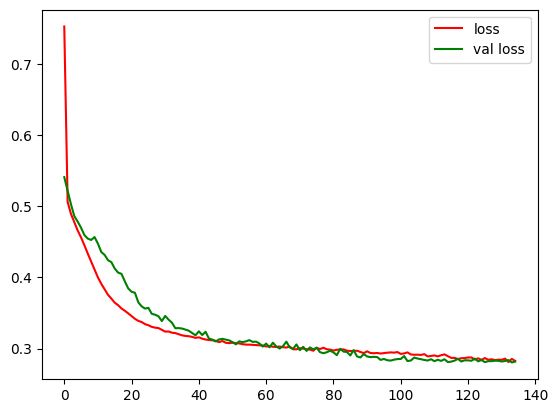

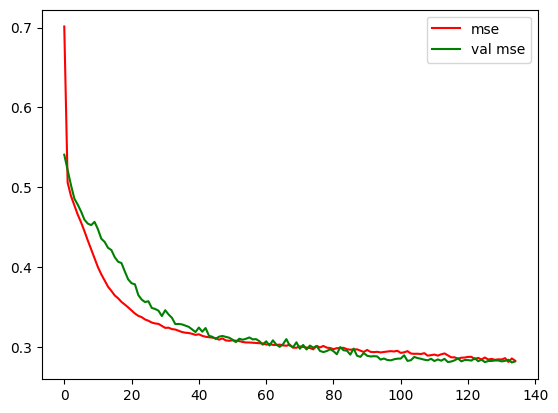

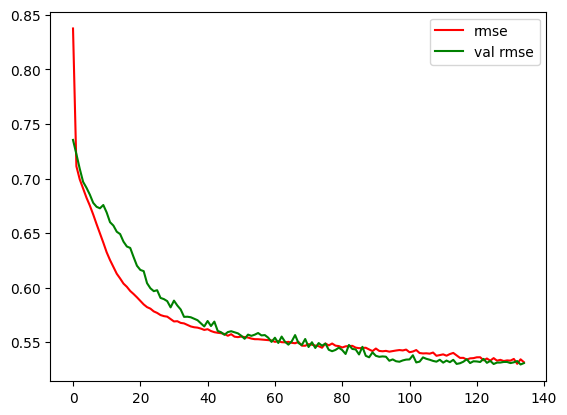

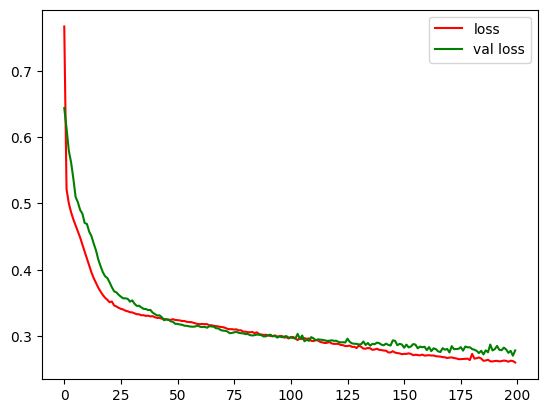

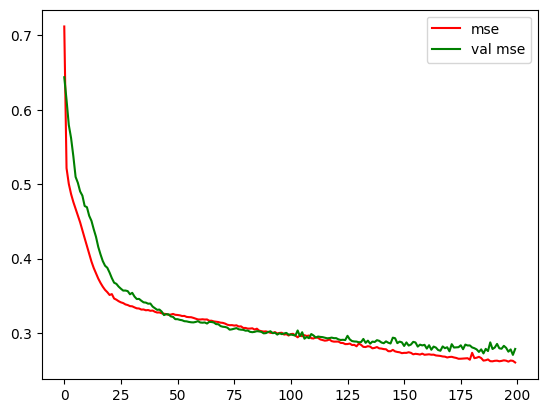

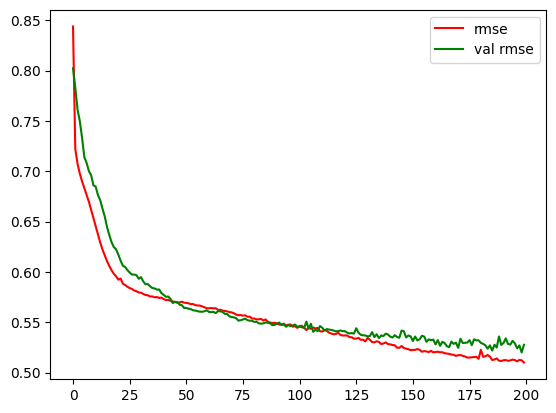

In [23]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [24]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type, zoom=4)
name = f"DistanceMatrix_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [25]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/california_housing/images_california_housing_DistanceMatrix_zoom4\regression.csv
Images shape:  (32, 32, 3)
Attributres:  8
Image size (pixels): 32


Epoch 1/200
516/516 - 36s - 70ms/step - loss: 0.9085 - mae: 0.6515 - mse: 0.8367 - r_square: 0.2737 - rmse: 0.9147 - val_loss: 0.5448 - val_mae: 0.5272 - val_mse: 0.5448 - val_r_square: 0.5534 - val_rmse: 0.7381
Epoch 2/200
516/516 - 30s - 57ms/step - loss: 0.5194 - mae: 0.5227 - mse: 0.5194 - r_square: 0.5852 - rmse: 0.7207 - val_loss: 0.5241 - val_mae: 0.5067 - val_mse: 0.5241 - val_r_square: 0.5717 - val_rmse: 0.7240
Epoch 3/200
516/516 - 30s - 58ms/step - loss: 0.4978 - mae: 0.5082 - mse: 0.4978 - r_square: 0.6025 - rmse: 0.7056 - val_loss: 0.4994 - val_mae: 0.4896 - val_mse: 0.4994 - val_r_square: 0.5909 - val_rmse: 0.7067
Epoch 4/200
516/516 - 30s - 58ms/step - loss: 0.4806 - mae: 0.4966 - mse: 0.4806 - r_square: 0.6160 - rmse: 0.6933 - val_loss: 0.4947 - val_mae: 0.4776 - val_mse: 0.4947 - val_r_square: 0.5957 - val_rmse: 0.7033
Epoch 5/200
516/516 - 30s - 57ms/step - loss: 0.4670 - mae: 0.4885 - mse: 0.4670 - r_square: 0.6269 - rmse: 0.6834 - val_loss: 0.4845 - val_mae: 0.4678 

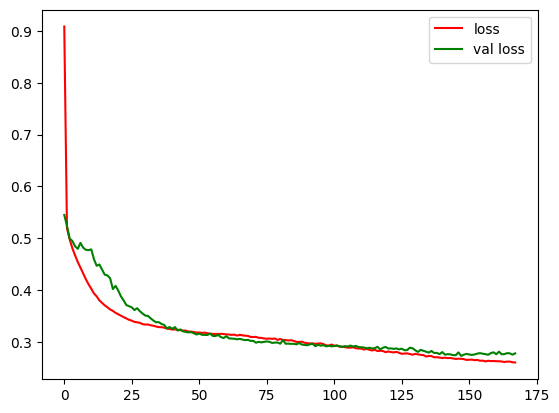

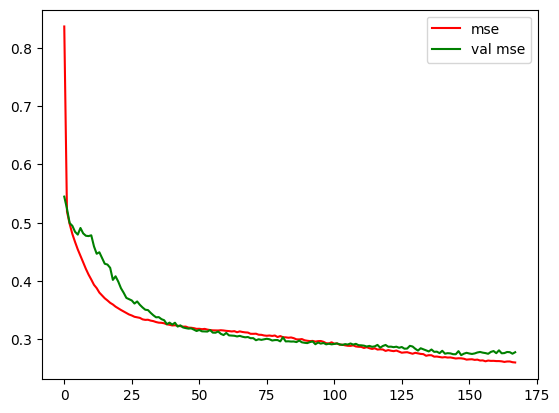

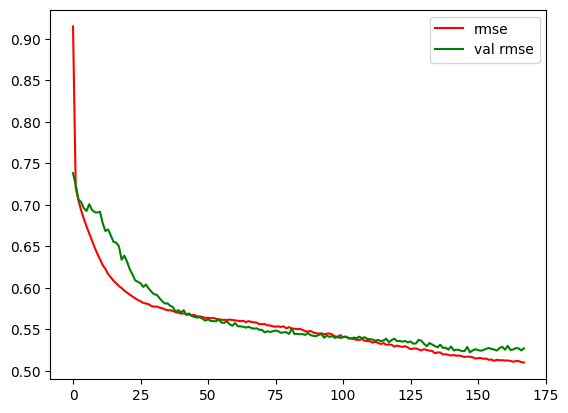

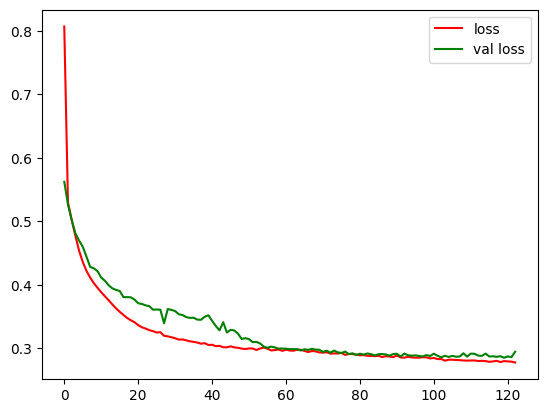

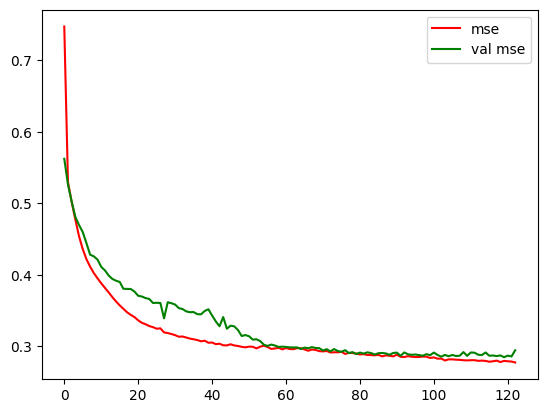

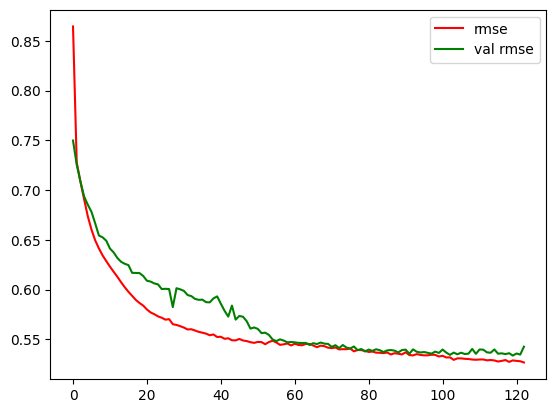

In [26]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

### EXPERIMENT 6: COMBINATION

In [27]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type)
name = f"Combination"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [28]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/california_housing/images_california_housing_Combination\regression.csv
Images shape:  (8, 8, 3)
Attributres:  8
Image size (pixels): 8


Epoch 1/200
516/516 - 10s - 19ms/step - loss: 0.9730 - mae: 0.6679 - mse: 0.8945 - r_square: 0.2229 - rmse: 0.9458 - val_loss: 0.5414 - val_mae: 0.5212 - val_mse: 0.5414 - val_r_square: 0.5563 - val_rmse: 0.7358
Epoch 2/200
516/516 - 3s - 7ms/step - loss: 0.5132 - mae: 0.5175 - mse: 0.5132 - r_square: 0.5895 - rmse: 0.7164 - val_loss: 0.5289 - val_mae: 0.4966 - val_mse: 0.5289 - val_r_square: 0.5688 - val_rmse: 0.7273
Epoch 3/200
516/516 - 4s - 7ms/step - loss: 0.4881 - mae: 0.4999 - mse: 0.4881 - r_square: 0.6099 - rmse: 0.6986 - val_loss: 0.4926 - val_mae: 0.4877 - val_mse: 0.4926 - val_r_square: 0.5973 - val_rmse: 0.7018
Epoch 4/200
516/516 - 4s - 7ms/step - loss: 0.4715 - mae: 0.4884 - mse: 0.4715 - r_square: 0.6234 - rmse: 0.6866 - val_loss: 0.4805 - val_mae: 0.4825 - val_mse: 0.4805 - val_r_square: 0.6084 - val_rmse: 0.6932
Epoch 5/200
516/516 - 3s - 7ms/step - loss: 0.4592 - mae: 0.4808 - mse: 0.4592 - r_square: 0.6330 - rmse: 0.6776 - val_loss: 0.4628 - val_mae: 0.4751 - val_ms

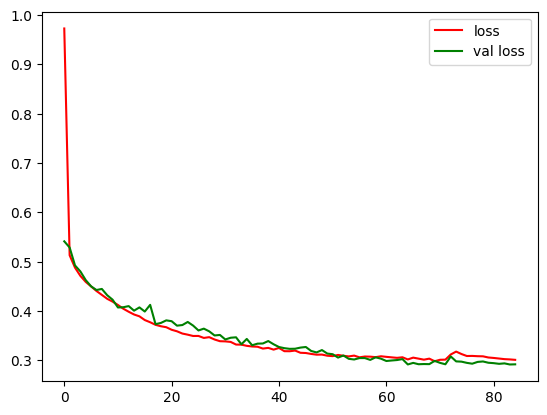

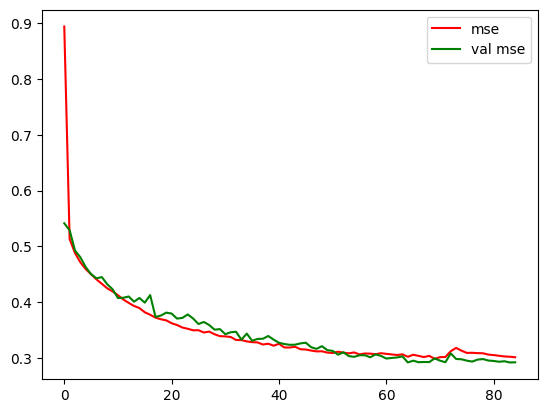

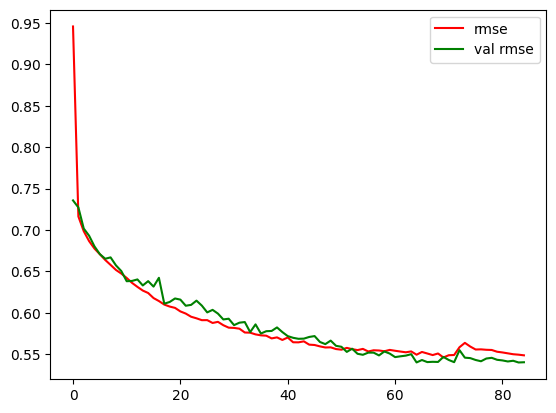

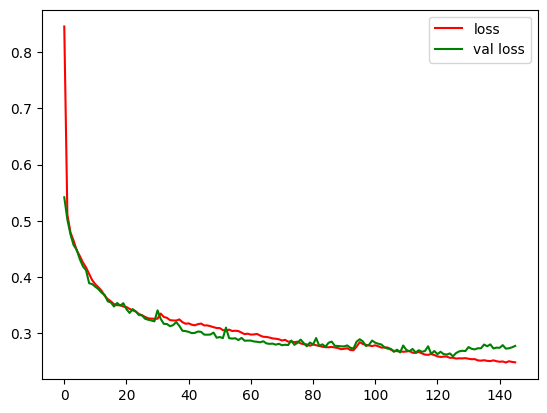

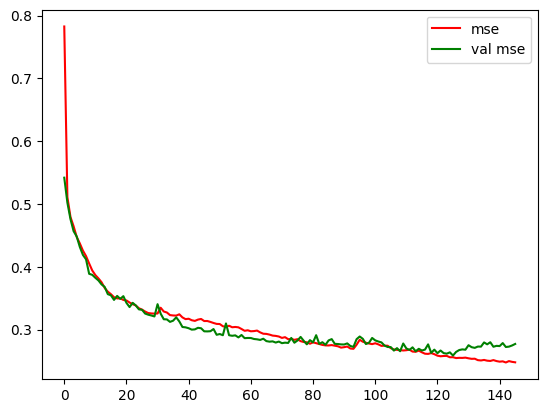

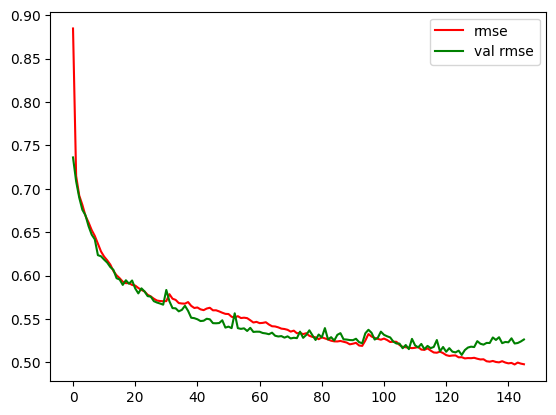

In [29]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [30]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type, zoom=2)
name = f"Combination_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [31]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/california_housing/images_california_housing_Combination_zoom2\regression.csv
Images shape:  (16, 16, 3)
Attributres:  8
Image size (pixels): 16


Epoch 1/200
516/516 - 11s - 21ms/step - loss: 0.8743 - mae: 0.6432 - mse: 0.8046 - r_square: 0.3000 - rmse: 0.8970 - val_loss: 0.5442 - val_mae: 0.5297 - val_mse: 0.5442 - val_r_square: 0.5535 - val_rmse: 0.7377
Epoch 2/200
516/516 - 5s - 9ms/step - loss: 0.5161 - mae: 0.5206 - mse: 0.5161 - r_square: 0.5876 - rmse: 0.7184 - val_loss: 0.5140 - val_mae: 0.5094 - val_mse: 0.5140 - val_r_square: 0.5806 - val_rmse: 0.7170
Epoch 3/200
516/516 - 4s - 8ms/step - loss: 0.4886 - mae: 0.5017 - mse: 0.4886 - r_square: 0.6095 - rmse: 0.6990 - val_loss: 0.4918 - val_mae: 0.4900 - val_mse: 0.4918 - val_r_square: 0.5990 - val_rmse: 0.7012
Epoch 4/200
516/516 - 4s - 8ms/step - loss: 0.4668 - mae: 0.4877 - mse: 0.4668 - r_square: 0.6272 - rmse: 0.6832 - val_loss: 0.4817 - val_mae: 0.4731 - val_mse: 0.4817 - val_r_square: 0.6078 - val_rmse: 0.6941
Epoch 5/200
516/516 - 5s - 9ms/step - loss: 0.4530 - mae: 0.4793 - mse: 0.4530 - r_square: 0.6380 - rmse: 0.6731 - val_loss: 0.4575 - val_mae: 0.4628 - val_ms

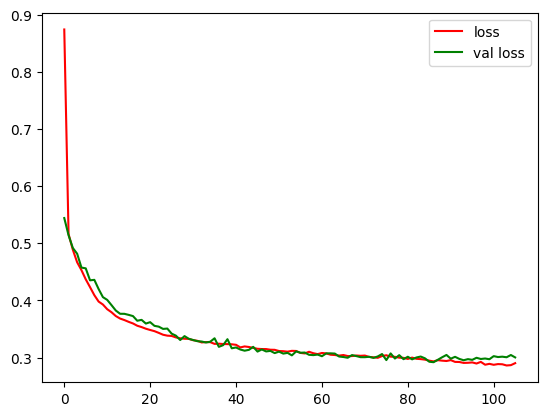

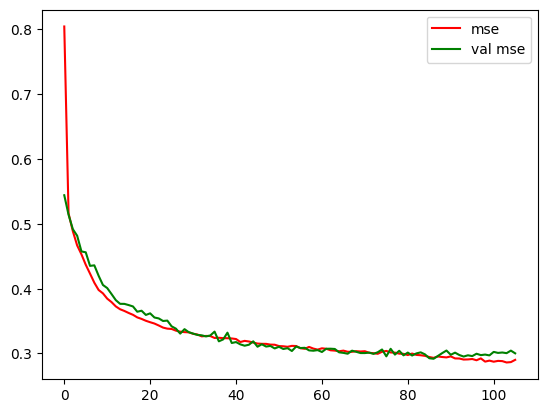

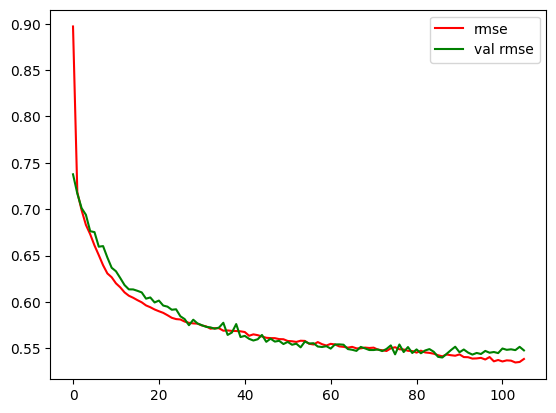

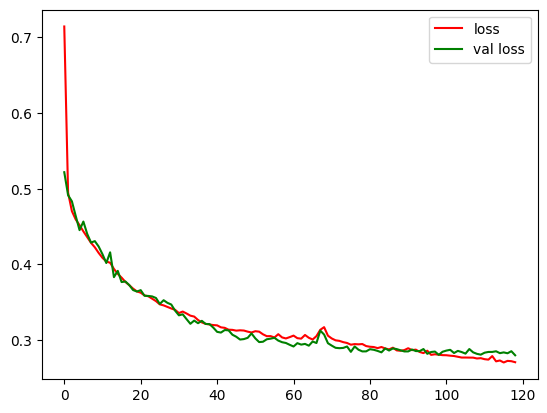

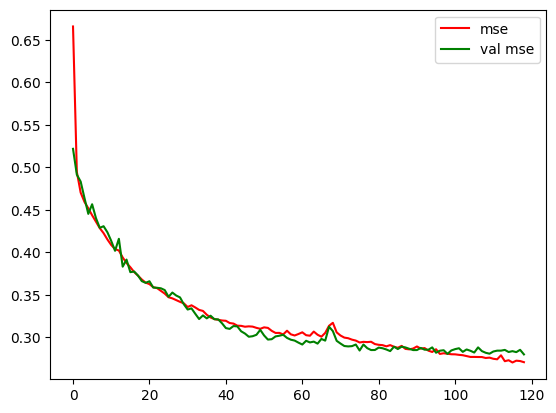

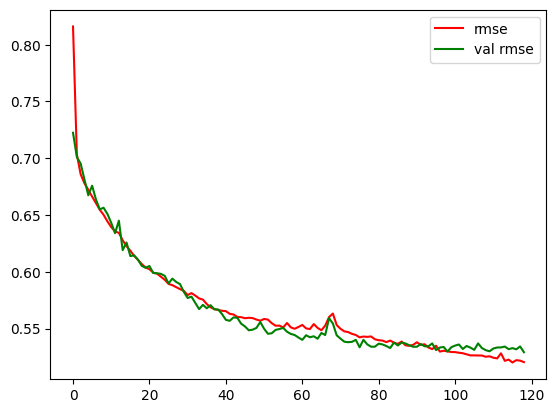

In [32]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [33]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type, zoom=4)
name = f"Combination_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [34]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/california_housing/images_california_housing_Combination_zoom4\regression.csv
Images shape:  (32, 32, 3)
Attributres:  8
Image size (pixels): 32


Epoch 1/200
516/516 - 37s - 72ms/step - loss: 0.7421 - mae: 0.6021 - mse: 0.6907 - r_square: 0.4077 - rmse: 0.8311 - val_loss: 0.5594 - val_mae: 0.5216 - val_mse: 0.5594 - val_r_square: 0.5474 - val_rmse: 0.7479
Epoch 2/200
516/516 - 30s - 59ms/step - loss: 0.4948 - mae: 0.5067 - mse: 0.4948 - r_square: 0.6042 - rmse: 0.7034 - val_loss: 0.5586 - val_mae: 0.5037 - val_mse: 0.5586 - val_r_square: 0.5466 - val_rmse: 0.7474
Epoch 3/200
516/516 - 32s - 62ms/step - loss: 0.4731 - mae: 0.4913 - mse: 0.4731 - r_square: 0.6217 - rmse: 0.6878 - val_loss: 0.5657 - val_mae: 0.4997 - val_mse: 0.5657 - val_r_square: 0.5390 - val_rmse: 0.7521
Epoch 4/200
516/516 - 32s - 62ms/step - loss: 0.4604 - mae: 0.4832 - mse: 0.4604 - r_square: 0.6321 - rmse: 0.6785 - val_loss: 0.4954 - val_mae: 0.4745 - val_mse: 0.4954 - val_r_square: 0.5980 - val_rmse: 0.7039
Epoch 5/200
516/516 - 31s - 61ms/step - loss: 0.4489 - mae: 0.4754 - mse: 0.4489 - r_square: 0.6412 - rmse: 0.6700 - val_loss: 0.4973 - val_mae: 0.4758 

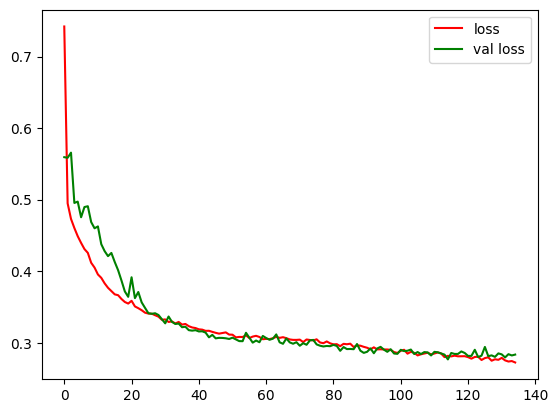

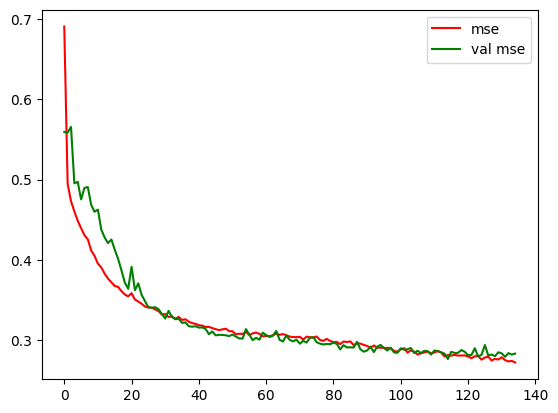

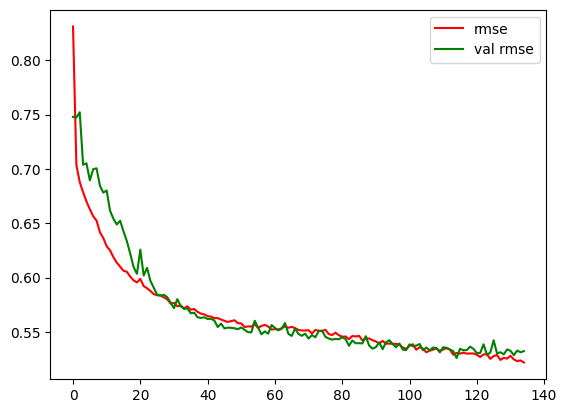

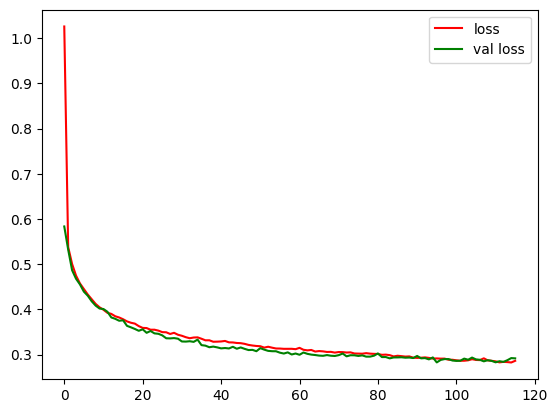

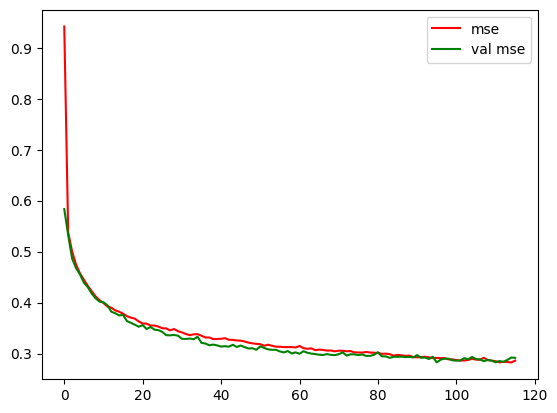

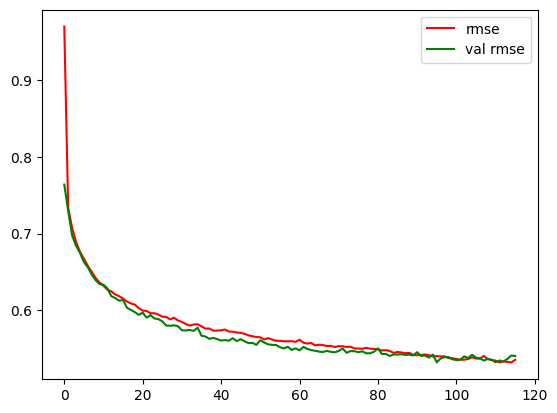

In [35]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

### EXPERIMENT 7: SUPERTML

In [36]:
#Select the model and the parameters
problem_type = "regression"
image_model = SuperTML(problem= problem_type)
name = f"SuperTML-EF"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [37]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

KeyboardInterrupt: 

In [ ]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = SuperTML(problem= problem_type, feature_importance=True, font_size=30)
name = f"SuperTML-VF_FS30"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, attributes, imgs_shape = load_and_preprocess_data(images_folder, image_model, problem_type)

In [ ]:
model1 = try_create_model(create_model1, attributes, imgs_shape)
model2 = try_create_model(create_model2, attributes, imgs_shape)
model3 = None

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

## FINAL METRICS AND BEST MODEL

In [ ]:
def find_best_model(base_path):
    best_rmse = float('inf')
    best_folder = None

    # Walk through all directories and files in the base path
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file == f'{dataset_name}_metrics.txt':
                file_path = os.path.join(root, file)
                
                # Read metrics from the file
                with open(file_path, 'r') as f:
                    metrics = f.read()
                
                # Parse the metrics into a dictionary
                metrics_dict = {}
                for line in metrics.splitlines():
                    key, value = line.split(': ')
                    metrics_dict[key.strip()] = float(value.strip())
                
                # Check if the current folder has a better validation loss
                if metrics_dict['test_rmse'] < best_rmse:
                    best_rmse = metrics_dict['test_rmse']
                    best_folder = root
    
    return best_folder, best_rmse

In [ ]:
import os

def rename_folder(old_folder_path):
    # Extract the base name of the old folder
    folder_name = os.path.basename(old_folder_path)
    
    # Create the new folder name by prepending "best_"
    new_folder_name = f"BEST_{folder_name}"
    
    # Get the parent directory of the old folder
    parent_dir = os.path.dirname(old_folder_path)
    
    # Create the full path for the new folder
    new_folder_path = os.path.join(parent_dir, new_folder_name)
    
    # Rename the folder
    os.rename(old_folder_path, new_folder_path)
    
    return new_folder_path

In [ ]:
# Usage
base_path = f"logs/{dataset_name}/ViT+MLP_Regression"
best_folder, best_rmse = find_best_model(base_path)
best_folder = rename_folder(best_folder)
print(f"Best model folder: {best_folder}")
print(f"Best RMSE: {best_rmse}")